# Clean Text Data

In [1]:
# # Check module locations if required
# import sys
# import pprint
# pprint.pprint(sys.path)

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import pickle
from tqdm.notebook import tqdm

import nltk

In [3]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

## Define Utility Functions

In [4]:
# Functions for map() or apply()

def get_word_count(x):
    '''
    Retun the number of words for the given text x.
    '''
    x = x.replace("[SECTION]", "")
    return len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', x))
        
def get_rate_change(x):
    '''
    Returns rate change decision of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
    
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['RateDecision']
    else:        
        return None

def get_rate(x):
    '''
    Returns rate of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
        
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['Rate']
    else:        
        return None

def get_next_meeting_date(x):
    '''
    Returns the next fomc meeting date for the given date x, referring to fomc_calendar DataFrame.
    Usually FOMC Meetings takes two days, so it starts searching from x+2.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None

    # Add two days to get the day after next
    x = x + dt.timedelta(days=2)
    
    # Just in case, sort fomc_calendar from older to newer
    fomc_calendar.sort_index(ascending=True, inplace=True)
    
    if fomc_calendar.index[0] > x:
        # If the date is older than the first FOMC Meeting, do not return any date.
        return None
    else:
        for i in range(len(fomc_calendar)):
            if x < fomc_calendar.index[i]:
                return fomc_calendar.index[i]
        # If x is greater than the newest FOMC meeting date, do not return any date.
        return None
    
def get_chairperson(x):
    '''
    Return a tuple of chairperson's Fullname for the given date x.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None
    
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

In [5]:
def reorganize_df(df, doc_type):
    '''
    Reorganize the loaded dataframe, which has been obrained by FomcGetData for further processing
        - Add type
        - Add word count
        - Add rate, decision (for meeting documents, None for the others)
        - Add next meeting date, rate and decision
        - Copy contents to org_text
        - Remove line breaks from contents in text
        - Split contents by "[SECTION]" to list in text_sections
    '''
    
    if doc_type in ('statement', 'minutes', 'presconf_script', 'meeting_script'):
        is_meeting_doc = True
    elif doc_type in ('speech', 'testimony'):
        is_meeting_doc = False
    else:
        print("Invalid doc_type [{}] is given!".format(doc_type))
        return None
    
    dict = {
        'type': doc_type,
        'date': df['date'],
        'title': df['title'],
        'speaker': df['speaker'],
        'word_count': df['contents'].map(get_word_count),
        'decision': df['date'].map(lambda x: get_rate_change(x) if is_meeting_doc else None),
        'rate': df['date'].map(lambda x: get_rate(x) if is_meeting_doc else None),
        'next_meeting': df['date'].map(get_next_meeting_date),
        'next_decision': df['date'].map(get_next_meeting_date).map(get_rate_change),
        'next_rate': df['date'].map(get_next_meeting_date).map(get_rate),        
        'text': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip()),
        'text_sections': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
        'org_text': df['contents']
    }

    new_df = pd.DataFrame(dict)
    new_df['decision'] = new_df['decision'].astype('Int8')
    new_df['next_decision'] = new_df['next_decision'].astype('Int8')
    print("No rate decision found: ", new_df['decision'].isnull().sum())
    print("Shape of the dataframe: ", new_df.shape)
    #new_df.dropna(subset=['decision'], axis=0, inplace=True)
    return new_df

In [6]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    '''
    Returns a list of split text of $split_len with overlapping of $overlap.
    Each item of the list will have around split_len length of text.
    '''
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    split_df['decision'] = split_df['decision'].astype('Int8')
    split_df['next_decision'] = split_df['next_decision'].astype('Int8')

    return split_df

In [7]:
def remove_short_section(df, min_words=50):
    '''
    Using 'text_sections' of the given dataframe, remove sections having less than min_words.
    It concatinate sections with a space, which exceeds min_words and update 'text'.
    As a fallback, keep a text which concatinates sections having more than 20 words and use it
     if there is no section having more than min_words.
    If there is no sections having more than 20 words, remove the row.
    '''
    new_df = df.copy()
    new_text_list = []
    new_text_section_list = []
    new_wc_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_text = ""
        bk_text = ""
        new_text_section = []
        bk_text_section = []
                
        for section in row['text_sections']:
            num_words = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section))
            if num_words > min_words:
                new_text += " " + section
                new_text_section.append(section)
            elif num_words > 20:
                bk_text += " " + section
                bk_text_section.append(section)
                
        
        new_text = new_text.strip()
        bk_text = bk_text.strip()
        
        if len(new_text) > 0:
            new_text_list.append(new_text)
            new_text_section_list.append(new_text_section)
        elif len(bk_text) > 0:
            new_text_list.append(bk_text)
            new_text_section_list.append(bk_text_section)
        else:
            new_text_list.append("")
            new_text_section_list.append("")
        
        # Update the word count
        new_wc_list.append(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', new_text_list[-1])))
        
    new_df['text'] = new_text_list
    new_df['word_count'] = new_wc_list
    
    return new_df.loc[new_df['word_count'] > 0]

def remove_short_nokeyword(df, keywords = ['rate', 'rates', 'federal fund', 'outlook', 'forecast', 'employ', 'economy'], min_times=2, min_words=50):
    '''
    Drop sections which do not have any one of keywords for min_times times
     before applying remove_short_section()
    '''
    
    new_df = df.copy()
    new_section_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_section = []
                
        for section in row['text_sections']:
            if len(set(section.split()).intersection(keywords)) >= min_times:
                new_section.append(section)
        
        new_section_list.append(new_section)
    
    new_df['text_sections'] = new_section_list
    
    return remove_short_section(new_df, min_words=min_words)

## Load Data

### Chairpersons

In [8]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2022,2,5)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

Surname FirstName   FromDate     ToDate
0    Volcker      Paul 1979-08-06 1987-08-10
1  Greenspan      Alan 1987-08-11 2006-01-31
2   Bernanke       Ben 2006-02-01 2014-01-31
3     Yellen     Janet 2014-02-03 2018-02-03
4     Powell    Jerome 2018-02-05 2022-02-05

### Load Calendar

In [9]:
file = open('../data/preprocessed/fomc_calendar.pickle', 'rb')

fomc_calendar = pd.read_pickle(file)
file.close()

print(fomc_calendar.shape)
fomc_calendar

(401, 8)


unscheduled  forecast  confcall  Rate  RateDiff  RateDecision  \
date                                                                        
1982-10-05        False     False     False   9.5      -0.5            -1   
1982-11-16        False     False     False   9.0      -0.5            -1   
1982-12-21        False     False     False   8.5       0.0             0   
1983-01-14        False     False      True   8.5       0.0             0   
1983-01-21        False     False      True   8.5       0.0             0   
...                 ...       ...       ...   ...       ...           ...   
2021-01-27        False     False     False   0.0       0.0             0   
2021-03-17        False      True     False   0.0       0.0             0   
2021-04-28        False     False     False   0.0       0.0             0   
2021-06-16        False      True     False   0.0       0.0             0   
2021-07-28        False     False     False   0.0       0.0             0   

           ChairPerson  RateChanged  
date                                 
1982-10-05         NaN            1  
1982-11-16         NaN            1  
1982-12-21         NaN            0  
1983-01-14         NaN            0  
1983-01-21         NaN            0  
...                ...          ...  
2021-01-27         NaN            0  
2021-03-17         NaN            0  
2021-04-28         NaN            0  
2021-06-16         NaN            0  
2021-07-28         NaN            0  

[401 rows x 8 columns]

### Statement

In [10]:
file = open('../data/FOMC/statement.pickle', 'rb')

statement_df = pd.read_pickle(file)
file.close()

print(statement_df.shape)
statement_df

(199, 4)


date  \
0   1994-02-04   
1   1994-03-22   
2   1994-04-18   
3   1994-05-17   
4   1994-08-16   
..         ...   
194 2021-01-27   
195 2021-03-17   
196 2021-04-28   
197 2021-06-16   
198 2021-07-28   

                                                                                                                                                                                                    contents  \
0    \n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...   
1    \n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...   
2    \n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...   
3    \n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...   
4    \n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...   
..                                                                                                                                                                                                       ...   
194  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
195  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
196  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
197  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
198  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   

            speaker           title  
0    Alan Greenspan  FOMC Statement  
1    Alan Greenspan  FOMC Statement  
2    Alan Greenspan  FOMC Statement  
3    Alan Greenspan  FOMC Statement  
4    Alan Greenspan  FOMC Statement  
..              ...             ...  
194   Jerome Powell  FOMC Statement  
195   Jerome Powell  FOMC Statement  
196   Jerome Powell  FOMC Statement  
197   Jerome Powell  FOMC Statement  
198   Jerome Powell  FOMC Statement  

[199 rows x 4 columns]

In [11]:
# Sample Contents - the 2nd last
print(statement_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Meeting Minutes

In [12]:
file = open('../data/FOMC/minutes.pickle', 'rb')

minutes_df = pd.read_pickle(file)
file.close()

print(minutes_df.shape)
minutes_df

(227, 4)


date  \
0   1993-02-03   
1   1993-03-23   
2   1993-05-18   
3   1993-07-07   
4   1993-08-17   
..         ...   
222 2020-12-16   
223 2021-01-27   
224 2021-03-17   
225 2021-04-28   
226 2021-06-16   

                                                                                                                                                                                                    contents  \
0    A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System in \r\n    Washington, D.C., on Tuesday, February 2, 1993, at...   
1    A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System in \r\n    Washington, D.C.,  on Tuesday, March 23,  1993,  a...   
2    A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System \r\n    in Washington, D.C.,  on Tuesday, May 18,  1993,  at ...   
3    A meeting of the Federal Open Market Committee was held in the \r\n    offices of the Board of Governors of the Federal Reserve System in \r\n    Washington, D.C., on Tuesday, July 6, 1993, at 2:3...   
4    A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System \r\n    in Washington, D.C., on Tuesday, August 17, 1993, at ...   
..                                                                                                                                                                                                       ...   
222  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
223  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
224  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
225  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
226  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   

            speaker                 title  
0    Alan Greenspan  FOMC Meeting Minutes  
1    Alan Greenspan  FOMC Meeting Minutes  
2    Alan Greenspan  FOMC Meeting Minutes  
3    Alan Greenspan  FOMC Meeting Minutes  
4    Alan Greenspan  FOMC Meeting Minutes  
..              ...                   ...  
222   Jerome Powell  FOMC Meeting Minutes  
223   Jerome Powell  FOMC Meeting Minutes  
224   Jerome Powell  FOMC Meeting Minutes  
225   Jerome Powell  FOMC Meeting Minutes  
226   Jerome Powell  FOMC Meeting Minutes  

[227 rows x 4 columns]

In [13]:
# Sample Contents - the 2nd last
print(minutes_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Meeting Transcripts

In [14]:
file = open('../data/FOMC/meeting_script.pickle', 'rb')

meeting_script_df = pd.read_pickle(file)
file.close()

print(meeting_script_df.shape)
meeting_script_df

(282, 4)


date  \
0   1980-01-09   
1   1980-02-05   
2   1980-03-18   
3   1980-04-22   
4   1980-05-20   
..         ...   
277 2014-06-18   
278 2014-07-30   
279 2014-09-17   
280 2014-10-29   
281 2014-12-17   

                                                                                                                                                                                                    contents  \
0    MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...   
1    CHAIRMAN VOLCKER. I will call the non-meeting to order. We\rare not in a meeting at this point anyway; we may be in a meeting\rlater. I would just remind all of you that I sent out a memorandum on...   
2    CHAIRMAN VOLCKER. The meeting can come to order, gentlemen\rand lady. We have a lot of business to dispose of at the start and I\rwill try to find my agenda, if you will excuse me a moment. We hav...   
3    CHAIRMAN VOLCKER.\rCan we come to order, ladies and\rgentlemen?\rI am delighted to say that our Vice Chairman, Mr. Solomon,\rwho was duly elected in absentia last time, is with us today. Welcome\r...   
4    CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.\rneed to approve the minutes.\r\n\n[SECTION]\n\nMR. SCHULTZ.\r\rSo moved.\r\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\r\n\n[SECTION]\n\nMS. TEETER...   
..                                                                                                                                                                                                       ...   
277  CHAIR YELLEN. I’d like to begin by welcoming three people to the table today: Stan\rFischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both Stan and\rLael, but both hav...   
278  CHAIR YELLEN. Good morning, everybody. I would like to begin today’s meeting by\rgiving the floor to President Fisher, who asked if he could take a minute to address the group.\r\n\n[SECTION]\n\nM...   
279  CHAIR YELLEN. Good morning, everybody.\rOur first two items this morning will be conducted in a joint meeting between the FOMC\rand the Board. I need a motion to close the Board meeting.\r\n\n[SEC...   
280  CHAIR YELLEN. I’d like to call this meeting to order. Before turning to our agenda,\rI’d like to say a few words about our communications with the public. Many of you will recall\rthat in June 201...   
281  CHAIR YELLEN. Good afternoon, everyone. I think we are ready to begin. The first\ritem we are going to consider is in a joint Board and FOMC meeting, so I need a motion to close\rthe Board meeting...   

          speaker                    title  
0           other  FOMC Meeting Transcript  
1           other  FOMC Meeting Transcript  
2           other  FOMC Meeting Transcript  
3           other  FOMC Meeting Transcript  
4           other  FOMC Meeting Transcript  
..            ...                      ...  
277  Janet Yellen  FOMC Meeting Transcript  
278  Janet Yellen  FOMC Meeting Transcript  
279  Janet Yellen  FOMC Meeting Transcript  
280  Janet Yellen  FOMC Meeting Transcript  
281  Janet Yellen  FOMC Meeting Transcript  

[282 rows x 4 columns]

In [15]:
# Sample Contents - the 2nd last
print(meeting_script_df['contents'].iloc[-1])

the Board meeting.

[SECTION]

MR. FISCHER. So moved.

[SECTION]

Simon to give us his report on market developments.

[SECTION]

to answer questions before moving on to Lorie’s part.

[SECTION]

CHAIR YELLEN. Questions for Simon? President Fisher.

[SECTION]

want to clarify that. So it’s mainly energy-driven.

[SECTION]

right.

[SECTION]

because you referenced them just now.

[SECTION]



[SECTION]

in mortgage-backed securities. Is that correct?

[SECTION]

MR. POTTER. It’s $2.5 trillion in Treasuries, I thought.

[SECTION]

Treasury redemptions in 2015, so nothing to speak of—

[SECTION]

MR. POTTER. That’s correct.

[SECTION]

for 2015 will be approximately $20 billion per month.

[SECTION]

MR. POTTER. Maybe a little bit higher, but about that level.

[SECTION]

net issuance.

[SECTION]

MR. POTTER. Correct.

[SECTION]

So it’s really taking five years, and, therefore, we would reduce by $900 billion over that fiveyear period. Correct?

[SECTION]

MR. POTTER. Yes. That’s the po

### Press Conference Transcripts

In [16]:
file = open('../data/FOMC/presconf_script.pickle', 'rb')

presconf_script_df = pd.read_pickle(file)
file.close()

print(presconf_script_df.shape)
presconf_script_df

(50, 4)


date  \
0  2011-04-27   
1  2011-06-22   
2  2011-11-02   
3  2012-01-25   
4  2012-04-25   
..        ...   
45 2021-01-27   
46 2021-03-17   
47 2021-04-28   
48 2021-06-16   
49 2021-07-28   

                                                                                                                                                                                                   contents  \
0   CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ...   
1   CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place\rthe decision in the context of our economic projections an...   
2   CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome.\rIn my opening remarks, I will briefly review today’s policy decision of the Federal Open\rour policy strategy. I will then be glad to take y...   
3   CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks I will briefly review today’s policy decision by the Federal Open\rto you regarding the Committee’s longer-run policy goals an...   
4   CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize\rtoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s\rpolicy decision in th...   
..                                                                                                                                                                                                      ...   
45  CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed\rto achieving the monetary policy goals that Congress has given us: maximum employment and\rprice stability. Since t...   
46  CHAIR POWELL. Good afternoon. I would like to start by noting that it has been a full\ryear since the pandemic arrived with force on our shores. Looking back, it was clear that\raddressing a fast-...   
47  CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed\rto achieving the monetary policy goals that Congress has given us: maximum employment and\rprice stability.\rToday ...   
48  CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed\rto achieving the monetary policy goals that Congress has given us: maximum employment and\rprice stability.\rToday ...   
49  CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed\rto achieving the monetary policy goals that Congress has given us: maximum employment and\rprice stability.\rToday ...   

          speaker                             title  
0    Ben Bernanke  FOMC Press Conference Transcript  
1    Ben Bernanke  FOMC Press Conference Transcript  
2    Ben Bernanke  FOMC Press Conference Transcript  
3    Ben Bernanke  FOMC Press Conference Transcript  
4    Ben Bernanke  FOMC Press Conference Transcript  
..            ...                               ...  
45  Jerome Powell  FOMC Press Conference Transcript  
46  Jerome Powell  FOMC Press Conference Transcript  
47  Jerome Powell  FOMC Press Conference Transcript  
48  Jerome Powell  FOMC Press Conference Transcript  
49  Jerome Powell  FOMC Press Conference Transcript  

[50 rows x 4 columns]

In [17]:
# Sample Contents - the 2nd last
print(presconf_script_df['contents'].iloc[-1])

Thank you. I look forward to your questions.

[SECTION]

MICHELLE SMITH. Thank you. Let’s go to Steve Liesman with CNBC.

[SECTION]

to an announcement of an actual reduction in the purchases of your assets. Thank you.

[SECTION]

want to see some strong job numbers. And, and that’s, that’s kind of the idea.

[SECTION]

side? Thank you.

[SECTION]

toward our target.

[SECTION]

MICHELLE SMITH. Thank you. Ann Saphir with Reuters.

[SECTION]

sorry.

[SECTION]

CHAIR POWELL. Yes, yes. We can hear you.

[SECTION]

your thinking on, on the taper? Thanks.

[SECTION]

that might work out, so we’ll just be monitoring it—monitoring it carefully.

[SECTION]

MICHELLE SMITH. Thank you. We’ll go to Nick Timiraos at the Wall Street Journal.

[SECTION]

some time?

[SECTION]

when we’ll ask that question. That is when that, that will become a real question for us.

[SECTION]

MICHELLE SMITH. Thank you. Jeanna Smialek at the New York Times.

[SECTION]

potential liftoff down the road? And if you co

### Speech

In [18]:
file = open('../data/FOMC/speech.pickle', 'rb')

speech_df = pd.read_pickle(file)
file.close()

print(speech_df.shape)
speech_df

(1538, 4)


date  \
0    1996-06-13   
1    1996-06-18   
2    1996-09-08   
3    1996-09-19   
4    1996-10-02   
...         ...   
1533 2021-07-30   
1534 2021-08-03   
1535 2021-08-04   
1536 2021-08-05   
1537 2021-08-17   

                                                                                                                                                                                                     contents  \
0     Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...   
1     Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...   
2     Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment.  But I al...   
3     Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...   
4     Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...   
...                                                                                                                                                                                                       ...   
1533  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
1534  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
1535  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
1536  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
1537  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   

                             speaker  \
0            Chairman Alan Greenspan   
1     Governor Edward W. Kelley, Jr.   
2         Governor Laurence H. Meyer   
3            Chairman Alan Greenspan   
4       Governor Lawrence B. Lindsey   
...                              ...   
1533          Governor Lael Brainard   
1534     Governor Michelle W. Bowman   
1535   Vice Chair Richard H. Clarida   
1536  Governor Christopher J. Waller   
1537          Chair Jerome H. Powell   

                                                                   title  
0                                    Bank supervision in a world economy  
1                           Developments in electronic money and banking  
2                                Monetary policy objectives and strategy  
3                              Regulation and electronic payment systems  
4                                         Small business is big business  
...                                                                  ...  
1533  Assessing Progress as the Economy Moves from Reopening to Recovery  
1534                                                   Welcoming Remarks  
1535          Outlooks, Outcomes, and Prospects for U.S. Monetary Policy  
1536                            CBDC: A So

In [19]:
# Sample Contents - the 2nd last
print(speech_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Testimony

In [20]:
file = open('../data/FOMC/testimony.pickle', 'rb')

testimony_df = pd.read_pickle(file)
file.close()

print(testimony_df.shape)
testimony_df

(449, 4)


date  \
0   1996-06-26   
1   1996-07-17   
2   1996-07-18   
3   1996-07-24   
4   1996-07-26   
..         ...   
444 2021-03-23   
445 2021-04-15   
446 2021-05-19   
447 2021-06-22   
448 2021-07-14   

                                                                                                                                                                                                    contents  \
0    \n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n     the supervision of bank sales practices on behalf of ...   
1    \n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n     and Urban Affairs to discuss actions that the Feder...   
2    Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT...   
3    \n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...   
4    \n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...   
..                                                                                                                                                                                                       ...   
444  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
445  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
446  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
447  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   
448  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...   

                                                                                         speaker  \
0                                                                 Governor Edward W. Kelley, Jr.   
1    Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation   
2                                                                        Chairman Alan Greenspan   
3                                                                       Governor Janet L. Yellen   
4                                                                        Chairman Alan Greenspan   
..                                                                                           ...   
444                                                                       Chair Jerome H. Powell   
445                                                          Mark Van Der Weide, General Counsel   
446                                                 Vice Chair for Supervision Randal K. Quarles   
447                                                                       Chair Jerome H. Powell   
448                                                                       Chair Jerome H. Powell   

                                                                                               

In [21]:
# Sample Contents - the 2nd last
print(testimony_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

## Statements DataFrame

In [22]:
statement_df.head()

date  \
0 1994-02-04   
1 1994-03-22   
2 1994-04-18   
3 1994-05-17   
4 1994-08-16   

                                                                                                                                                                                                  contents  \
0  \n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...   
1  \n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...   
2  \n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...   
3  \n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...   
4  \n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...   

          speaker           title  
0  Alan Greenspan  FOMC Statement  
1  Alan Greenspan  FOMC Statement  
2  Alan Greenspan  FOMC Statement  
3  Alan Greenspan  FOMC Statement  
4  Alan Greenspan  FOMC Statement

### Add Quantitative Easing as a Lower event

In [23]:
# Add When QE was first announced on 2008-11-25. No statemenet on that day.

if statement_df.loc[statement_df['date'] == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    qe_text = "The Federal Reserve announced on Tuesday that it will initiate a program "\
              "to purchase the direct obligations of housing-related government-sponsored "\
              "enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks "\
              "--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, "\
              "and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages "\
              "have widened appreciably of late.  This action is being taken to reduce the cost "\
              "and increase the availability of credit for the purchase of houses, which in turn "\
              "should support housing markets and foster improved conditions in financial markets "\
              "more generally. Purchases of up to $100 billion in GSE direct obligations under "\
              "the program will be conducted with the Federal Reserve's primary dealers through "\
              "a series of competitive auctions and will begin next week.  Purchases of up to "\
              "$500 billion in MBS will be conducted by asset managers selected via a competitive "\
              "process with a goal of beginning these purchases before year-end.  "\
              "Purchases of both direct obligations and MBS are expected to take place over "\
              "several quarters.  Further information regarding the operational details of this "\
              "program will be provided after consultation with market participants."
    statement_df = statement_df.append(
        pd.Series([dt.datetime.strptime('2008-11-25', '%Y-%m-%d'), qe_text, 'Ben Bernanke', 'FOMC statement'], index=statement_df.columns),
        ignore_index=True
    )
    

### Process the dataframe

In [24]:
# Reorganize the dataframe
proc_statement_df = reorganize_df(statement_df, 'statement')

No rate decision found:  0
Shape of the dataframe:  (200, 13)


In [25]:
# Check the returned dataframe
proc_statement_df

type       date           title         speaker  word_count  \
0    statement 1994-02-04  FOMC Statement  Alan Greenspan          99   
1    statement 1994-03-22  FOMC Statement  Alan Greenspan          40   
2    statement 1994-04-18  FOMC Statement  Alan Greenspan          37   
3    statement 1994-05-17  FOMC Statement  Alan Greenspan         160   
4    statement 1994-08-16  FOMC Statement  Alan Greenspan         137   
..         ...        ...             ...             ...         ...   
195  statement 2021-03-17  FOMC Statement   Jerome Powell         629   
196  statement 2021-04-28  FOMC Statement   Jerome Powell         626   
197  statement 2021-06-16  FOMC Statement   Jerome Powell         624   
198  statement 2021-07-28  FOMC Statement   Jerome Powell         638   
199  statement 2008-11-25  FOMC statement    Ben Bernanke         192   

     decision  rate next_meeting  next_decision  next_rate  \
0           1  3.25   1994-02-28              0       3.25   
1           1  3.50   1994-04-18              1       3.75   
2           1  3.75   1994-05-17              1       4.25   
3           1  4.25   1994-07-06              0       4.25   
4           1  4.75   1994-09-27              0       4.75   
..        ...   ...          ...            ...        ...   
195         0  0.00   2021-04-28              0       0.00   
196         0  0.00   2021-06-16              0       0.00   
197         0  0.00   2021-07-28              0       0.00   
198         0  0.00          NaT           <NA>        NaN   
199        -1  0.00   2008-12-16             -1       0.00   

                                                                                                                                                                                                        text  \
0    [SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be assoc...   
1    [SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...   
2    [SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...   
3    [SECTION]The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.[SECTION]The Board approved an increase in th...   
4    [SECTION]The Federal Reserve announced today the following monetary policy actions:[SECTION]These measures were taken against the background of evidence of continuing strength in the economic expa...   
..                                                                                                                                                                                                       ...   
195  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...   
196  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...   
197  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...   
198  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...   
199  The Federal Reserve announced on Tuesday that it will initiate a program to purchase the direct

In [26]:
# Check which row does not have rate
proc_statement_df.loc[proc_statement_df['rate'].isnull()]

Empty DataFrame
Columns: [type, date, title, speaker, word_count, decision, rate, next_meeting, next_decision, next_rate, text, text_sections, org_text]
Index: []

In [27]:
x = dt.datetime.strptime('2019-01-01', '%Y-%m-%d')
fomc_calendar.loc[fomc_calendar.index > x]

unscheduled  forecast  confcall  Rate  RateDiff  RateDecision  \
date                                                                        
2019-01-30        False     False     False  2.25      0.00             0   
2019-03-20        False      True     False  2.25      0.00             0   
2019-05-01        False     False     False  2.25      0.00             0   
2019-06-19        False      True     False  2.25      0.00             0   
2019-07-31        False     False     False  2.00     -0.25            -1   
...                 ...       ...       ...   ...       ...           ...   
2021-01-27        False     False     False  0.00      0.00             0   
2021-03-17        False      True     False  0.00      0.00             0   
2021-04-28        False     False     False  0.00      0.00             0   
2021-06-16        False      True     False  0.00      0.00             0   
2021-07-28        False     False     False  0.00      0.00             0   

           ChairPerson  RateChanged  
date                                 
2019-01-30         NaN            0  
2019-03-20         NaN            0  
2019-05-01         NaN            0  
2019-06-19         NaN            0  
2019-07-31         NaN            1  
...                ...          ...  
2021-01-27         NaN            0  
2021-03-17         NaN            0  
2021-04-28         NaN            0  
2021-06-16         NaN            0  
2021-07-28         NaN            0  

[27 rows x 8 columns]

In [28]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_statement_df = remove_short_section(proc_statement_df, min_words=50)
proc_statement_df


type       date           title         speaker  word_count  \
0    statement 1994-02-04  FOMC Statement  Alan Greenspan          99   
1    statement 1994-03-22  FOMC Statement  Alan Greenspan          40   
2    statement 1994-04-18  FOMC Statement  Alan Greenspan          37   
3    statement 1994-05-17  FOMC Statement  Alan Greenspan          57   
4    statement 1994-08-16  FOMC Statement  Alan Greenspan          51   
..         ...        ...             ...             ...         ...   
195  statement 2021-03-17  FOMC Statement   Jerome Powell         358   
196  statement 2021-04-28  FOMC Statement   Jerome Powell         359   
197  statement 2021-06-16  FOMC Statement   Jerome Powell         354   
198  statement 2021-07-28  FOMC Statement   Jerome Powell         368   
199  statement 2008-11-25  FOMC statement    Ben Bernanke         192   

     decision  rate next_meeting  next_decision  next_rate  \
0           1  3.25   1994-02-28              0       3.25   
1           1  3.50   1994-04-18              1       3.75   
2           1  3.75   1994-05-17              1       4.25   
3           1  4.25   1994-07-06              0       4.25   
4           1  4.75   1994-09-27              0       4.75   
..        ...   ...          ...            ...        ...   
195         0  0.00   2021-04-28              0       0.00   
196         0  0.00   2021-06-16              0       0.00   
197         0  0.00   2021-07-28              0       0.00   
198         0  0.00          NaT           <NA>        NaN   
199        -1  0.00   2008-12-16             -1       0.00   

                                                                                                                                                                                                        text  \
0    Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...   
1    Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...   
2    Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...   
3    In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...   
4    In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...   
..                                                                                                                                                                                                       ...   
195  The COVID-19 pandemic is causing tremendous human and economic hardship across the United States and around the world. Following a moderation in the pace of the recovery, indicators of economic ac...   
196  The COVID-19 pandemic is causing tremendous human and economic hardship across the United States and around the world. Amid progress on vaccinations and strong policy support, indicators of econom...   
197  Progress on vaccinations has reduced the spread of COVID-19 in the United States. Amid this progress and strong policy support, indicators of economic activity and employment have strengthened. Th...   
198  With progress on vaccinations and strong policy support, indicators of economic activity and employment have continued to strengthen. The sectors most adversely affected by the pandemic have shown...   
199  The Federal Reserve announced on Tuesday that it will initiate a program to purchase the direct

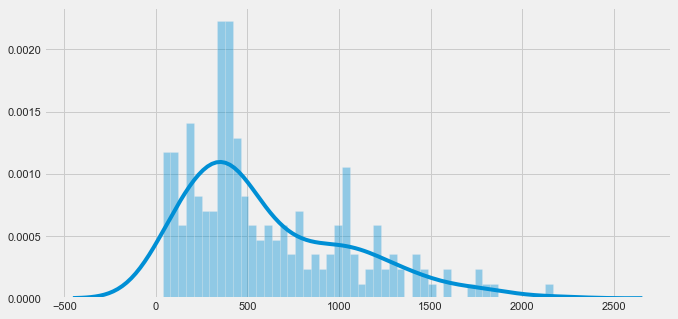

In [29]:
plt.figure(figsize=(10,5))
sns.distplot(proc_statement_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [30]:
split_statement_df = get_split_df(proc_statement_df)
split_statement_df.tail(10)

type       date           title        speaker  word_count  \
840  statement 2021-04-28  FOMC Statement  Jerome Powell         200   
841  statement 2021-04-28  FOMC Statement  Jerome Powell         200   
842  statement 2021-04-28  FOMC Statement  Jerome Powell          59   
843  statement 2021-06-16  FOMC Statement  Jerome Powell         200   
844  statement 2021-06-16  FOMC Statement  Jerome Powell         200   
845  statement 2021-06-16  FOMC Statement  Jerome Powell          54   
846  statement 2021-07-28  FOMC Statement  Jerome Powell         200   
847  statement 2021-07-28  FOMC Statement  Jerome Powell         200   
848  statement 2021-07-28  FOMC Statement  Jerome Powell          68   
849  statement 2008-11-25  FOMC statement   Ben Bernanke         192   

     decision  rate next_meeting  next_decision  next_rate  \
840         0   0.0   2021-06-16              0        0.0   
841         0   0.0   2021-06-16              0        0.0   
842         0   0.0   2021-06-16              0        0.0   
843         0   0.0   2021-07-28              0        0.0   
844         0   0.0   2021-07-28              0        0.0   
845         0   0.0   2021-07-28              0        0.0   
846         0   0.0          NaT           <NA>        NaN   
847         0   0.0          NaT           <NA>        NaN   
848         0   0.0          NaT           <NA>        NaN   
849        -1   0.0   2008-12-16             -1        0.0   

                                                                                                                                                                                                        text  \
840  The COVID pandemic is causing tremendous human and economic hardship across the United States and around the world Amid progress on vaccinations and strong policy support indicators of economic ac...   
841  are achieved The Committee decided to keep the target range for the federal funds rate at to percent and expects it will be appropriate to maintain this target range until labor market conditions ...   
842  the economic outlook The Committee would be prepared to adjust the stance of monetary policy as appropriate if risks emerge that could impede the attainment of the Committee's goals The Committee'...   
843  Progress on vaccinations has reduced the spread of COVID in the United States Amid this progress and strong policy support indicators of economic activity and employment have strengthened The sect...   
844  to keep the target range for the federal funds rate at to percent and expects it will be appropriate to maintain this target range until labor market conditions have reached levels consistent with...   
845  would be prepared to adjust the stance of monetary policy as appropriate if risks emerge that could impede the attainment of the Committee's goals The Committee's assessments will take into accoun...   
846  With progress on vaccinations and strong policy support indicators of economic activity and employment have continued to strengthen The sectors most adversely affected by the pandemic have shown i...   
847  funds rate at to percent and expects it will be appropriate to maintain this target range until labor market conditions have reached levels consistent with the Committee's assessments of maximum e...   
848  continue to monitor the implications of incoming information for the economic outlook The Committee would be prepared to adjust the stance of monetary policy as appropriate if risks emerge that co...   
849  The Federal Reserve announced on Tuesday that it will initiate a program to purchase the direct obligations of housing related government sponsored enterprises GSEs Fannie Mae Freddie Mac and the ...   

                                                                                                                                                                                               text_sections  \
840  [The Federal Reserve, the centra

### Filter out by keywords

In [31]:
# Keep sections having keywords and long enough
keyword_statement_df = remove_short_nokeyword(proc_statement_df)
keyword_statement_df.reset_index(drop=True, inplace=True)
print(keyword_statement_df.shape)
keyword_statement_df


(110, 13)


type       date           title         speaker  word_count  \
0    statement 1994-05-17  FOMC Statement  Alan Greenspan          38   
1    statement 1994-11-15  FOMC Statement  Alan Greenspan          27   
2    statement 1996-01-31  FOMC Statement  Alan Greenspan         391   
3    statement 1997-03-25  FOMC Statement  Alan Greenspan         405   
4    statement 1998-09-29  FOMC Statement  Alan Greenspan         373   
..         ...        ...             ...             ...         ...   
105  statement 2020-11-05  FOMC Statement   Jerome Powell          45   
106  statement 2020-12-16  FOMC Statement   Jerome Powell          45   
107  statement 2021-04-28  FOMC Statement   Jerome Powell          36   
108  statement 2021-06-16  FOMC Statement   Jerome Powell          39   
109  statement 2021-07-28  FOMC Statement   Jerome Powell         223   

     decision  rate next_meeting  next_decision  next_rate  \
0           1  4.25   1994-07-06              0       4.25   
1           1  5.50   1994-12-20              0       5.50   
2          -1  5.25   1996-03-26              0       5.25   
3           1  5.50   1997-05-20              0       5.50   
4          -1  5.25   1998-10-15             -1       5.00   
..        ...   ...          ...            ...        ...   
105         0  0.00   2020-12-16              0       0.00   
106         0  0.00   2021-01-27              0       0.00   
107         0  0.00   2021-06-16              0       0.00   
108         0  0.00   2021-07-28              0       0.00   
109         0  0.00          NaT           <NA>        NaN   

                                                                                                                                                                                                        text  \
0    The Board approved an increase in the discount rate from 3 percent to 3-1/2 percent, effective immediately, and the Federal Open Market Committee agreed that this increase should be allowed to sho...   
1                                        In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.   
2    For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective im...   
3    For immediate release\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage point to around 5-1/2 pe...   
4    For immediate releaseThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1/...   
..                                                                                                                                                                                                       ...   
105  The path of the economy will depend significantly on the course of the virus. The ongoing public health crisis will continue to weigh on economic activity, employment, and inflation in the near te...   
106  The path of the economy will depend significantly on the course of the virus. The ongoing public health crisis will continue to weigh on economic activity, employment, and inflation in the near te...   
107  The path of the economy will depend significantly on the course of the virus, including progress on vaccinations. The ongoing public health crisis continues to weigh on the economy, and risks to t...   
108  The path of the economy will depend significantly on the course of the virus. Progress on vaccinations will likely continue to reduce the effects of the public health crisis on the economy, but ri...   
109  The Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over t

In [32]:
# Drop text during the process to reduce the output size
proc_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Minutes DataFrame

In [33]:
minutes_df.head()

date  \
0 1993-02-03   
1 1993-03-23   
2 1993-05-18   
3 1993-07-07   
4 1993-08-17   

                                                                                                                                                                                                  contents  \
0  A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System in \r\n    Washington, D.C., on Tuesday, February 2, 1993, at...   
1  A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System in \r\n    Washington, D.C.,  on Tuesday, March 23,  1993,  a...   
2  A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System \r\n    in Washington, D.C.,  on Tuesday, May 18,  1993,  at ...   
3  A meeting of the Federal Open Market Committee was held in the \r\n    offices of the Board of Governors of the Federal Reserve System in \r\n    Washington, D.C., on Tuesday, July 6, 1993, at 2:3...   
4  A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System \r\n    in Washington, D.C., on Tuesday, August 17, 1993, at ...   

          speaker                 title  
0  Alan Greenspan  FOMC Meeting Minutes  
1  Alan Greenspan  FOMC Meeting Minutes  
2  Alan Greenspan  FOMC Meeting Minutes  
3  Alan Greenspan  FOMC Meeting Minutes  
4  Alan Greenspan  FOMC Meeting Minutes

In [34]:
# Reorganize the dataframe
proc_minutes_df = reorganize_df(minutes_df, 'minutes')

No rate decision found:  0
Shape of the dataframe:  (227, 13)


In [35]:
# Check the returned dataframe
proc_minutes_df

type       date                 title         speaker  word_count  \
0    minutes 1993-02-03  FOMC Meeting Minutes  Alan Greenspan       10241   
1    minutes 1993-03-23  FOMC Meeting Minutes  Alan Greenspan        5792   
2    minutes 1993-05-18  FOMC Meeting Minutes  Alan Greenspan        5001   
3    minutes 1993-07-07  FOMC Meeting Minutes  Alan Greenspan        7064   
4    minutes 1993-08-17  FOMC Meeting Minutes  Alan Greenspan        4679   
..       ...        ...                   ...             ...         ...   
222  minutes 2020-12-16  FOMC Meeting Minutes   Jerome Powell        8133   
223  minutes 2021-01-27  FOMC Meeting Minutes   Jerome Powell       12388   
224  minutes 2021-03-17  FOMC Meeting Minutes   Jerome Powell        8631   
225  minutes 2021-04-28  FOMC Meeting Minutes   Jerome Powell        8656   
226  minutes 2021-06-16  FOMC Meeting Minutes   Jerome Powell        9442   

     decision  rate next_meeting  next_decision  next_rate  \
0           0   3.0   1993-02-18              0        3.0   
1           0   3.0   1993-05-18              0        3.0   
2           0   3.0   1993-07-07              0        3.0   
3           0   3.0   1993-08-17              0        3.0   
4           0   3.0   1993-09-21              0        3.0   
..        ...   ...          ...            ...        ...   
222         0   0.0   2021-01-27              0        0.0   
223         0   0.0   2021-03-17              0        0.0   
224         0   0.0   2021-04-28              0        0.0   
225         0   0.0   2021-06-16              0        0.0   
226         0   0.0   2021-07-28              0        0.0   

                                                                                                                                                                                                        text  \
0    A meeting of the Federal Open Market Committee was held in     the offices of the Board of Governors of the Federal Reserve System in     Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p....   
1    A meeting of the Federal Open Market Committee was held in     the offices of the Board of Governors of the Federal Reserve System in     Washington, D.C.,  on Tuesday, March 23,  1993,  at  9:00 ...   
2    A meeting of the Federal Open Market Committee was held in     the offices of the Board of Governors of the Federal Reserve System     in Washington, D.C.,  on Tuesday, May 18,  1993,  at  9:00 a....   
3    A meeting of the Federal Open Market Committee was held in the     offices of the Board of Governors of the Federal Reserve System in     Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. a...   
4    A meeting of the Federal Open Market Committee was held in     the offices of the Board of Governors of the Federal Reserve System     in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a.m...   
..                                                                                                                                                                                                       ...   
222  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...   
223  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...   
224  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...   
225  The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...   
226  The Federal Reserve, the central bank of the 

In [36]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

Empty DataFrame
Columns: [type, date, title, speaker, word_count, decision, rate, next_meeting, next_decision, next_rate, text, text_sections, org_text]
Index: []

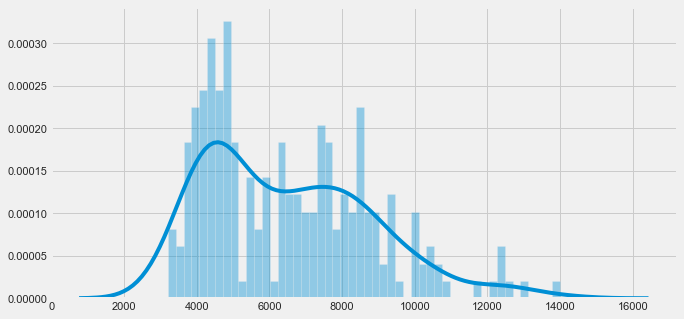

In [37]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [38]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

Empty DataFrame
Columns: [type, date, title, speaker, word_count, decision, rate, next_meeting, next_decision, next_rate, text, text_sections, org_text]
Index: []

Meeting minutes includes various topics, so it makes sense to extract relevant sections. <br />
Check some common sections.

In [39]:
# Check what kind of sections are in common

a = minutes_df.contents.str.lower().str.count('staff economic outlook')
b = minutes_df.contents.str.lower().str.count('developments in financial markets')
c = minutes_df.contents.str.lower().str.count('staff review of the economic situation')
d = minutes_df.contents.str.lower().str.count('staff review of the financial situation')
e = minutes_df.contents.str.lower().str.count('participants\' views on current condition')
f = minutes_df.contents.str.lower().str.count('committee policy action')
g = minutes_df.contents.str.lower().str.count('voting for this action')
h = minutes_df.contents.str.lower().str.count('federal fund')

pd.options.display.max_rows = 300
pd.DataFrame({'date': minutes_df['date'], 'a': a, 'b':b, 'c':c, 'd':d, 'e':e, 'f':f, 'g':g, 'h':h})

date  a  b  c  d  e  f  g   h
0   1993-02-03  0  0  0  0  0  0  0   1
1   1993-03-23  0  0  0  0  0  0  0   3
2   1993-05-18  0  0  0  0  0  0  0   1
3   1993-07-07  0  0  0  0  0  0  0   3
4   1993-08-17  0  0  0  0  0  0  0   1
5   1993-09-21  0  0  0  0  0  0  0   1
6   1993-11-16  0  0  0  0  0  0  0   1
7   1993-12-21  0  0  0  0  0  0  0   2
8   1994-02-04  0  1  0  0  0  0  0   0
9   1994-03-22  0  0  0  0  0  0  0   2
10  1994-03-22  0  0  0  0  0  0  0   2
11  1994-05-17  0  0  0  0  0  0  0   1
12  1994-07-06  0  0  0  0  0  0  0   1
13  1994-08-16  0  0  0  0  0  0  0   1
14  1994-09-27  0  0  0  0  0  0  0   2
15  1994-11-15  0  0  0  0  0  0  0   1
16  1994-12-20  0  0  0  0  0  0  0   0
17  1995-02-01  0  0  0  0  0  0  0   1
18  1995-03-28  0  1  0  0  0  0  0   1
19  1995-05-23  0  2  0  0  0  0  0   1
20  1995-07-06  0  0  0  0  0  0  0   2
21  1995-08-22  0  0  0  0  0  0  0   1
22  1995-09-26  0  0  0  0  0  0  0   1
23  1995-11-15  0  0  0  0  0  0  0   2
24  1995-12-19  0  0  0  0  0  0  0   3
25  1996-01-31  0  0  0  0  0  0  0   3
26  1996-03-26  0  0  0  0  0  0  0   1
27  1996-05-21  0  0  0  0  0  0  0   2
28  1996-07-03  0  0  0  0  0  0  0   2
29  1996-08-20  0  0  0  0  0  0  0   1
30  1996-09-24  0  0  0  0  0  0  0   1
31  1996-11-13  0  0  0  0  0  0  0   1
32  1996-12-17  0  0  0  0  0  0  0   1
33  1997-02-05  0  0  0  0  0  0  0   1
34  1997-03-25  0  0  0  0  0  0  0   1
35  1997-05-20  0  0  0  0  0  0  0   0
36  1997-07-02  0  0  0  0  0  0  0   1
37  1997-08-19  0  0  0  0  0  0  0   9
38  1997-09-30  0  0  0  0  0  0  0   8
39  1997-11-12  0  0  0  0  0  0  0   8
40  1997-12-16  0  0  0  0  0  0  0   8
41  1998-02-04  0  0  0  0  0  0  0   8
42  1998-03-31  0  0  0  0  0  0  0   8
43  1998-05-19  0  0  0  0  0  0  0   9
44  1998-07-01  0  0  0  0  0  0  0   8
45  1998-08-18  0  1  0  0  0  0  0   7
46  1998-09-29  0  1  0  0  0  0  0  10
47  1998-11-17  0  0  0  0  0  0  0  13
48  1998-12-22  0  0  0  0  0  0  0   4
49  1999-02-03  0  0  0  0  0  0  0   3
50  1999-03-30  0  0  0  0  0  0  0   4
51  1999-05-18  0  0  0  0  0  0  0   5
52  1999-06-30  0  0  0  0  0  0  0   5
53  1999-08-24  0  0  0  0  0  0  0   5
54  1999-10-05  0  0  0  0  0  0  0   4
55  1999-11-16  0  0  0  0  0  0  0   5
56  1999-12-21  0  0  0  0  0  0  0   6
57  2000-02-02  0  0  0  0  0  0  0   7
58  2000-03-21  0  0  0  0  0  0  0   4
59  2000-05-16  0  0  0  0  0  0  0   4
60  2000-06-28  0  0  0  0  0  0  0   5
61  2000-08-22  0  0  0  0  0  0  0   4
62  2000-10-03  0  0  0  0  0  0  0   3
63  2000-11-15  0  0  0  0  0  0  0   4
64  2000-12-19  0  1  0  0  0  0  0   7
65  2000-12-19  0  1  0  0  0  0  0   7
66  2001-01-31  0  0  0  0  0  0  0   7
67  2001-03-20  0  0  0  0  0  0  0   8
68  2001-03-20  0  0  0  0  0  0  0   8
69  2001-03-20  0  0  0  0  0  0  0   8
70  2001-05-15  0  1  0  0  0  0  0   9
71  2001-06-27  0  0  0  0  0  0  0   6
72  2001-08-21  0  0  0  0  0  0  0   7
73  2001-08-21  0  0  0  0  0  0  0   7
74  2001-08-21  0  0  0  0  0  0  0   7
75  2001-10-02  0  0  0  0  0  0  0  10
76  2001-11-06  0  0  0  0  0  0  0   7
77  2001-12-11  0  0  0  0  0  0  0   7
78  2002-01-30  0  0  0  0  0  0  0   6
79  2002-03-19  0  0  0  0  0  0  0   5
80  2002-05-07  0  0  0  0  0  0  0   4
81  2002-06-26  0  0  0  0  0  0  0   4
82  2002-08-13  0  0  0  0  0  0  0   4
83  2002-09-24  0  0  0  0  0  0  0   2
84  2002-11-06  0  0  0  0  0  0  0   7
85  2002-12-10  0  0  0  0  0  0  0   3
86  2003-01-29  0  0  0  0  0  0  0   5
87  2003-03-18  0  0  0  0  0  0  0   2
88  2003-05-06  0  0  0  0  0  0  0   3
89  2003-06-25  0  0  0  0  0  0  0  12
90  2003-08-12  0  0  0  0  0  0  0   4
91  2003-09-16  0  0  0  0  0  0  0   5
92  2003-10-28  0  0  0  0  0  0  0   6
93  2003-12-09  0  0  0  0  0  0  0   5
94  2004-01-28  0  0  0  0  0  0  0   3
95  2004-03-16  0  0  0  0  0  0  0   4
96  2004-05-04  0  0  0  0  0  0  0   5
97  2004-06-30  0  0  0  0  0  0  0   4
98  2004-08-10  0  0  0  0  0  0  0   4
99  2004-0

In [40]:
pd.options.display.max_rows = 20

Sections are added from time to time. For example, quarterly economic forcast started in 2009. Leave manually handling those for now, take another approach to filter sentenses by length and key words here.

In [41]:
proc_minutes_df = remove_short_section(proc_minutes_df, min_words=50)

### Split contents to max 200 words

In [42]:
split_minutes_df = get_split_df(proc_minutes_df)
print(split_minutes_df.shape)
split_minutes_df.tail(10)


(8465, 13)


type       date                 title        speaker  word_count  \
8455  minutes 2021-06-16  FOMC Meeting Minutes  Jerome Powell         200   
8456  minutes 2021-06-16  FOMC Meeting Minutes  Jerome Powell         200   
8457  minutes 2021-06-16  FOMC Meeting Minutes  Jerome Powell         200   
8458  minutes 2021-06-16  FOMC Meeting Minutes  Jerome Powell         200   
8459  minutes 2021-06-16  FOMC Meeting Minutes  Jerome Powell         200   
8460  minutes 2021-06-16  FOMC Meeting Minutes  Jerome Powell         200   
8461  minutes 2021-06-16  FOMC Meeting Minutes  Jerome Powell         200   
8462  minutes 2021-06-16  FOMC Meeting Minutes  Jerome Powell         200   
8463  minutes 2021-06-16  FOMC Meeting Minutes  Jerome Powell         200   
8464  minutes 2021-06-16  FOMC Meeting Minutes  Jerome Powell          68   

      decision  rate next_meeting  next_decision  next_rate  \
8455         0   0.0   2021-07-28              0        0.0   
8456         0   0.0   2021-07-28              0        0.0   
8457         0   0.0   2021-07-28              0        0.0   
8458         0   0.0   2021-07-28              0        0.0   
8459         0   0.0   2021-07-28              0        0.0   
8460         0   0.0   2021-07-28              0        0.0   
8461         0   0.0   2021-07-28              0        0.0   
8462         0   0.0   2021-07-28              0        0.0   
8463         0   0.0   2021-07-28              0        0.0   
8464         0   0.0   2021-07-28              0        0.0   

                                                                                                                                                                                                         text  \
8455  somewhat earlier than they had anticipated at previous meetings in light of incoming data Some participants saw the incoming data as providing a less clear signal about the underlying economic mom...   
8456  MBS purchases Several participants saw benefits to reducing the pace of these purchases more quickly or earlier than Treasury purchases in light of valuation pressures in housing markets Several o...   
8457  the possibility of further downward pressure on these rates in the near term as likely Consequently they noted that an adjustment to the Federal Reserve's administered rates would help keep the fe...   
8458  support the economy and the flow of credit to U S households and businesses Members also agreed that the path of the economy would depend significantly on the course of the virus Progress on vacci...   
8459  expectations remain well anchored at percent Members expected to maintain an accommodative stance of monetary policy until those outcomes were achieved All members agreed to keep the target range ...   
8460  conditions thereby supporting the flow of credit to households and businesses Members agreed that in assessing the appropriate stance of monetary policy they would continue to monitor the implicat...   
8461  causing tremendous human and economic hardship and that the ongoing public health crisis continues to weigh on the economy Instead they agreed to say that progress on vaccinations had reduced the ...   
8462  goal the Committee will aim to achieve inflation moderately above percent for some time so that inflation averages percent over time and term inflation expectations remain well anchored at percent...   
8463  stability goals These asset purchases help foster smooth market functioning and accommodative financial conditions thereby supporting the flow of credit to households and businesses In assessing t...   
8464  points above the bottom of the target range for the federal funds rate is intended to foster trading in the federal funds market at rates well within the Federal Open Market Committee's target ran...   

                                                                                                                                                                       

### Filter out by keywords

In [43]:
# Keep sections having keywords and long enough
keyword_minutes_df = remove_short_nokeyword(proc_minutes_df)
keyword_minutes_df.reset_index(drop=True, inplace=True)
print(keyword_minutes_df.shape)
keyword_minutes_df


(227, 13)


type       date                 title         speaker  word_count  \
0    minutes 1993-02-03  FOMC Meeting Minutes  Alan Greenspan        2119   
1    minutes 1993-03-23  FOMC Meeting Minutes  Alan Greenspan        1770   
2    minutes 1993-05-18  FOMC Meeting Minutes  Alan Greenspan        1182   
3    minutes 1993-07-07  FOMC Meeting Minutes  Alan Greenspan        2636   
4    minutes 1993-08-17  FOMC Meeting Minutes  Alan Greenspan        1272   
..       ...        ...                   ...             ...         ...   
222  minutes 2020-12-16  FOMC Meeting Minutes   Jerome Powell        1988   
223  minutes 2021-01-27  FOMC Meeting Minutes   Jerome Powell        1935   
224  minutes 2021-03-17  FOMC Meeting Minutes   Jerome Powell        1847   
225  minutes 2021-04-28  FOMC Meeting Minutes   Jerome Powell        1673   
226  minutes 2021-06-16  FOMC Meeting Minutes   Jerome Powell        2273   

     decision  rate next_meeting  next_decision  next_rate  \
0           0   3.0   1993-02-18              0        3.0   
1           0   3.0   1993-05-18              0        3.0   
2           0   3.0   1993-07-07              0        3.0   
3           0   3.0   1993-08-17              0        3.0   
4           0   3.0   1993-09-21              0        3.0   
..        ...   ...          ...            ...        ...   
222         0   0.0   2021-01-27              0        0.0   
223         0   0.0   2021-03-17              0        0.0   
224         0   0.0   2021-04-28              0        0.0   
225         0   0.0   2021-06-16              0        0.0   
226         0   0.0   2021-07-28              0        0.0   

                                                                                                                                                                                                        text  \
0    The nominal U.S. merchandise trade deficit widened slightly     in November. For October and November together, however, the deficit     narrowed a little from its average rate in the third quarte...   
1    In foreign exchange markets, the trade-weighted value of the     dollar in terms of the other G-10 currencies fell on balance over the     intermeeting period. The dollar depreciated through late ...   
2    In foreign exchange markets, the trade-weighted value of the     dollar in terms of the other G-10 currencies declined somewhat on     balance over the intermeeting period. The dollar depreciated ...   
3    Other short-term interest rates also were little changed on     balance over the period since the May meeting. Early in the period,     unexpectedly robust employment data for May, coupled with me...   
4    Money market interest rates were little changed on balance     over the intermeeting period, while rates on intermediate-term U.S.     Treasury obligations and on fixed-rate mortgages dropped slig...   
..                                                                                                                                                                                                       ...   
222  Total nonfarm payroll employment continued to increase solidly over October and November, though the rate of monthly job gains was more moderate than the substantial thirdâquarter pace. Through ...   
223  Employment, inflation, and long-term interest rates fluctuate over time in response to economic and financial disturbances. Monetary policy plays an important role in stabilizing the economy in re...   
224  Developments in Financial Markets and Open Market OperationsThe manager turned first to a discussion of financial market developments. In the United States, the trend toward higher longer-term yie...   
225  The manager turned next to money markets and the Federal Reserve's balance sheet. Reserve balances increased further this intermeeting period to a record level of $3.9 trillion. The effective fede...   
226  Over the period, market participants focused 

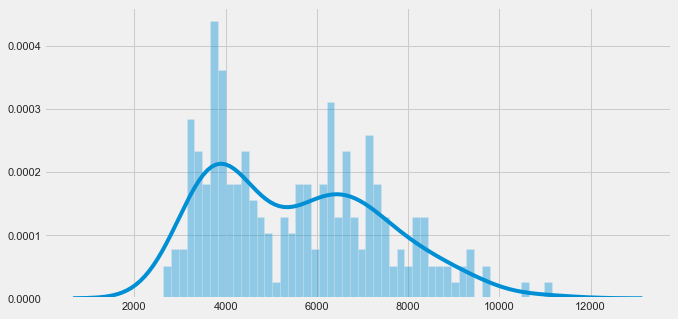

In [44]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [45]:
# Drop text during the process to reduce the output size
proc_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Press Conference Script DataFrame
Press Conference transcripts are available only from 2011

In [46]:
# Sample
print(presconf_script_df['contents'][2])

Thank you for your patience, and I would be happy to take your questions.

[SECTION]

policy, in your opinion?

[SECTION]

at least, not proved to be very valid.

[SECTION]

STEVE LIESMAN. Was the letter appropriate?

[SECTION]

going to do.

[SECTION]

And what are your views on the advantages and disadvantages of that approach?

[SECTION]

date—at this time—any radical change in framework. We are going to stay within the dualmandate approach that we’ve been using until this point.

[SECTION]

economy?

[SECTION]

address inequality per se.

[SECTION]

how people should interpret those two messages?

[SECTION]

necessarily move in mid-2013 with those conditions prevailing that you described.

[SECTION]

proposal?

[SECTION]

conditions were appropriate. So the answer is yes, we would certainly look at that.

[SECTION]

know that U.S. companies don’t about investing in the U.S.?

[SECTION]

but it’s still obviously too low to be consistent with a full employment economy.

[SECTION]

th

In [47]:
# Reorganize the dataframe
proc_presconf_script_df = reorganize_df(presconf_script_df, 'presconf_script')


No rate decision found:  0
Shape of the dataframe:  (50, 13)


In [48]:
# Check the returned dataframe
proc_presconf_script_df

type       date                             title  \
0   presconf_script 2011-04-27  FOMC Press Conference Transcript   
1   presconf_script 2011-06-22  FOMC Press Conference Transcript   
2   presconf_script 2011-11-02  FOMC Press Conference Transcript   
3   presconf_script 2012-01-25  FOMC Press Conference Transcript   
4   presconf_script 2012-04-25  FOMC Press Conference Transcript   
..              ...        ...                               ...   
45  presconf_script 2021-01-27  FOMC Press Conference Transcript   
46  presconf_script 2021-03-17  FOMC Press Conference Transcript   
47  presconf_script 2021-04-28  FOMC Press Conference Transcript   
48  presconf_script 2021-06-16  FOMC Press Conference Transcript   
49  presconf_script 2021-07-28  FOMC Press Conference Transcript   

          speaker  word_count  decision  rate next_meeting  next_decision  \
0    Ben Bernanke        8761         0   0.0   2011-06-22              0   
1    Ben Bernanke        7363         0   0.0   2011-08-01              0   
2    Ben Bernanke        7358         0   0.0   2011-11-28              0   
3    Ben Bernanke       10134         0   0.0   2012-03-13              0   
4    Ben Bernanke        7678         0   0.0   2012-06-20             -1   
..            ...         ...       ...   ...          ...            ...   
45  Jerome Powell        9570         0   0.0   2021-03-17              0   
46  Jerome Powell       10475         0   0.0   2021-04-28              0   
47  Jerome Powell       10027         0   0.0   2021-06-16              0   
48  Jerome Powell       10714         0   0.0   2021-07-28              0   
49  Jerome Powell        9773         0   0.0          NaT           <NA>   

    next_rate  \
0         0.0   
1         0.0   
2         0.0   
3         0.0   
4         0.0   
..        ...   
45        0.0   
46        0.0   
47        0.0   
48        0.0   
49        NaN   

                                                                                                                                                                                                       text  \
0   CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly econ...   
1   CHAIRMAN BERNANKE. Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and ou...   
2   CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your ...   
3   CHAIRMAN BERNANKE. Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and st...   
4   CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the co...   
..                                                                                                                                                                                                      ...   
45  CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us: maximum employment andprice stability. Since the b...   
46  CHAIR POWELL. Good afternoon. I would like to start by noting that it has been a fullyear since the pandemic arrived with force on our shores. Looking back, it was clear thataddressing a fast-movi...   
47  CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us: maximum employment andprice stability.Today my col...  

In [49]:
# Check which row does not have rate
proc_presconf_script_df.loc[proc_presconf_script_df['rate'].isnull()]

Empty DataFrame
Columns: [type, date, title, speaker, word_count, decision, rate, next_meeting, next_decision, next_rate, text, text_sections, org_text]
Index: []

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [50]:
script_data_list = []

for i, row in tqdm(proc_presconf_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_presconf_script_df.columns

presconf_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
presconf_script_speaker_df

type       date                             title  \
0     presconf_script 2011-04-27  FOMC Press Conference Transcript   
1     presconf_script 2011-04-27  FOMC Press Conference Transcript   
2     presconf_script 2011-04-27  FOMC Press Conference Transcript   
3     presconf_script 2011-04-27  FOMC Press Conference Transcript   
4     presconf_script 2011-04-27  FOMC Press Conference Transcript   
...               ...        ...                               ...   
2540  presconf_script 2021-07-28  FOMC Press Conference Transcript   
2541  presconf_script 2021-07-28  FOMC Press Conference Transcript   
2542  presconf_script 2021-07-28  FOMC Press Conference Transcript   
2543  presconf_script 2021-07-28  FOMC Press Conference Transcript   
2544  presconf_script 2021-07-28  FOMC Press Conference Transcript   

                speaker  word_count  decision  rate next_meeting  \
0     CHAIRMAN BERNANKE        1509         0   0.0   2011-06-22   
1              QUESTION          61         0   0.0   2011-06-22   
2     CHAIRMAN BERNANKE         185         0   0.0   2011-06-22   
3              QUESTION          55         0   0.0   2011-06-22   
4     CHAIRMAN BERNANKE         303         0   0.0   2011-06-22   
...                 ...         ...       ...   ...          ...   
2540          GREG ROBB           7         0   0.0          NaT   
2541     MICHELLE SMITH          16         0   0.0          NaT   
2542            DON LEE          48         0   0.0          NaT   
2543       CHAIR POWELL         316         0   0.0          NaT   
2544     MICHELLE SMITH           8         0   0.0          NaT   

     next_decision  next_rate  \
0                0        0.0   
1                0        0.0   
2                0        0.0   
3                0        0.0   
4                0        0.0   
...            ...        ...   
2540          <NA>        NaN   
2541          <NA>        NaN   
2542          <NA>        NaN   
2543          <NA>        NaN   
2544          <NA>        NaN   

                                                                                                                                                                                                         text  \
0     Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections al...   
1     Mr. Chairman, tomorrow we’re going to get a pretty weak first-quarterGDP number. Your own projections for the year have been downgraded in this meeting. How—first of all, what do you see as the ca...   
2     You’re correct. We haven’t seen the GDP number yet. Butwe, like most private-sector forecasters, are expecting a relatively weak number for the firstquarter, maybe something a little under 2 perce...   
3     Mr. Chairman, given what you know about the pace of the economy now,what is your best guess for how soon the Fed needs to begin to withdraw its extraordinarystimulus for the economy? And could you...   
4     Well, currently as the statement suggests, we are in amoderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed,sustainable, as we believe it is. And we’ll also...   
...                                                                                                                                                                                                       ...   
2540                                                                                                                                             Thank you.
July 28, 2021Chair Powell’s Press ConferenceFINAL   
2541                                                                                                                            Thank you. We’ll go to Don Lee at the Los Angeles Times for thelast question.   
2542  Hi, Chair Powell. I wonder if you could talk about wages. Many workersseem 

In [51]:
# Filter by the word count
presconf_script_speaker_df = presconf_script_speaker_df.loc[presconf_script_speaker_df['word_count'] >= 50]

(1848, 13)


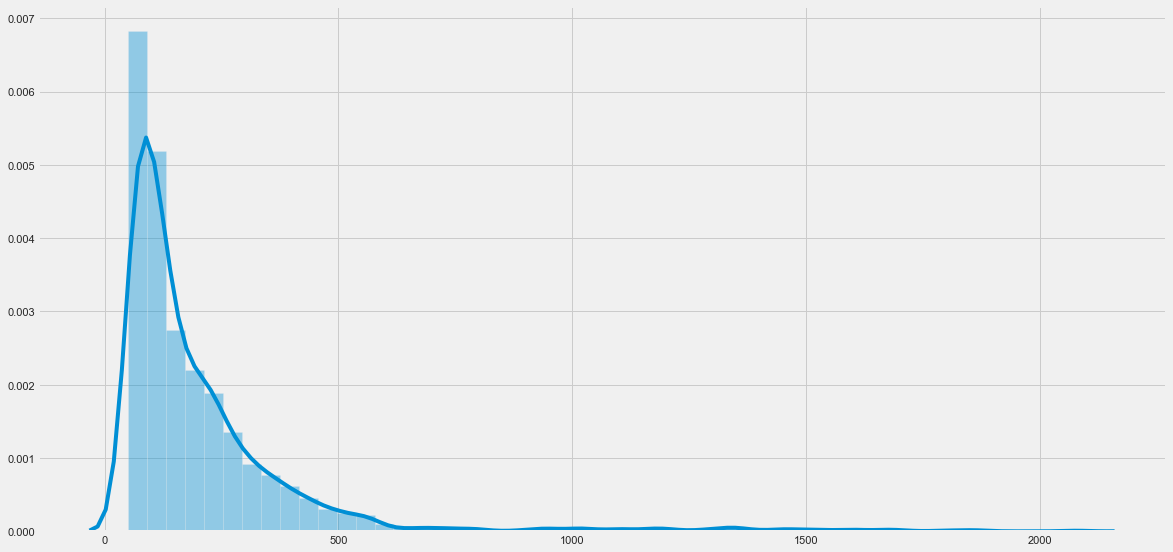

In [52]:
print(presconf_script_speaker_df.shape)
sns.distplot(presconf_script_speaker_df["word_count"].values, bins=50)

In [53]:
# Filter to have only chairperson's speak

tmp_list = []
for i, row in presconf_script_speaker_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = presconf_script_speaker_df.columns
presconf_script_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
presconf_script_chair_df

type       date                             title  \
0     presconf_script 2011-04-27  FOMC Press Conference Transcript   
1     presconf_script 2011-04-27  FOMC Press Conference Transcript   
2     presconf_script 2011-04-27  FOMC Press Conference Transcript   
3     presconf_script 2011-04-27  FOMC Press Conference Transcript   
4     presconf_script 2011-04-27  FOMC Press Conference Transcript   
...               ...        ...                               ...   
1084  presconf_script 2021-07-28  FOMC Press Conference Transcript   
1085  presconf_script 2021-07-28  FOMC Press Conference Transcript   
1086  presconf_script 2021-07-28  FOMC Press Conference Transcript   
1087  presconf_script 2021-07-28  FOMC Press Conference Transcript   
1088  presconf_script 2021-07-28  FOMC Press Conference Transcript   

            speaker  word_count  decision  rate next_meeting next_decision  \
0      Ben Bernanke        1509         0   0.0   2011-06-22             0   
1      Ben Bernanke         185         0   0.0   2011-06-22             0   
2      Ben Bernanke         303         0   0.0   2011-06-22             0   
3      Ben Bernanke         197         0   0.0   2011-06-22             0   
4      Ben Bernanke         158         0   0.0   2011-06-22             0   
...             ...         ...       ...   ...          ...           ...   
1084  Jerome Powell         481         0   0.0          NaT          <NA>   
1085  Jerome Powell         163         0   0.0          NaT          <NA>   
1086  Jerome Powell         269         0   0.0          NaT          <NA>   
1087  Jerome Powell         446         0   0.0          NaT          <NA>   
1088  Jerome Powell         316         0   0.0          NaT          <NA>   

      next_rate  \
0           0.0   
1           0.0   
2           0.0   
3           0.0   
4           0.0   
...         ...   
1084        NaN   
1085        NaN   
1086        NaN   
1087        NaN   
1088        NaN   

                                                                                                                                                                                                         text  \
0     Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections al...   
1     You’re correct. We haven’t seen the GDP number yet. Butwe, like most private-sector forecasters, are expecting a relatively weak number for the firstquarter, maybe something a little under 2 perce...   
2     Well, currently as the statement suggests, we are in amoderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed,sustainable, as we believe it is. And we’ll also...   
3     Thanks, Steve. First, I should start by saying that theSecretary of the Treasury, of course, is the spokesperson for U.S. policy on the dollar andSecretary Geithner had some words yesterday. Let m...   
4     Well, the dollar—the dollar fluctuates. One factor, forexample, that has caused fluctuations that have been quite extreme during the crisis has been thesafe-haven effect. So, for example, during t...   
...                                                                                                                                                                                                       ...   
1084  Right. So with inflation, as I mentioned, we’re, we look not just atthe headline number, but we look at all the components that go into the calculation of inflation.And if you do that, if you look...   
1085  So a number of participants raised that—the questions around MBSand tapering at, at today’s meeting, as a matter of fact, and yesterday’s meeting. And I’ll just saythat, generally speaking, I don’...   
1086  So on the standing repo facility, what is it going to do? So it, itreally is a backstop. So it’s, it’s set at 25 basis poin

In [54]:
# Combine scripts of the same speaker for the same day.
tmp_date = ''
tmp_speaker = ''
tmp_data = []

print('Before: ', presconf_script_chair_df.shape)

for i, row in tqdm(presconf_script_chair_df.iterrows()):
    if (row['date'] == tmp_date) and (row['speaker'] == tmp_speaker):
        tmp_data[-1]['text'] += row['text']
        tmp_data[-1]['word_count'] += row['word_count']
        tmp_data[-1]['text_sections'].append(row['text'])
    else:
        tmp_date = row['date']
        tmp_speaker = row['speaker']
        row['text_sections'] = [row['text']]
        tmp_data.append(row)

presconf_script_chair_day_df = pd.DataFrame(tmp_data)

print('After', presconf_script_chair_day_df.shape)
presconf_script_chair_day_df.head()

Before:  (1089, 13)



After (50, 13)


type       date                             title  \
0   presconf_script 2011-04-27  FOMC Press Conference Transcript   
21  presconf_script 2011-06-22  FOMC Press Conference Transcript   
40  presconf_script 2011-11-02  FOMC Press Conference Transcript   
62  presconf_script 2012-01-25  FOMC Press Conference Transcript   
81  presconf_script 2012-04-25  FOMC Press Conference Transcript   

         speaker  word_count  decision  rate next_meeting next_decision  \
0   Ben Bernanke        7047         0   0.0   2011-06-22             0   
21  Ben Bernanke        5635         0   0.0   2011-08-01             0   
40  Ben Bernanke        5519         0   0.0   2011-11-28             0   
62  Ben Bernanke        7488         0   0.0   2012-03-13             0   
81  Ben Bernanke        5453         0   0.0   2012-06-20            -1   

    next_rate  \
0         0.0   
21        0.0   
40        0.0   
62        0.0   
81        0.0   

                                                                                                                                                                                                       text  \
0   Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections al...   
21  Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and our policy strategy. ...   
40  Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your questions.As indica...   
62  Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and strategy. And finally...   
81  Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the context of our econom...   

                                                                                                                                                                                              text_sections  \
0   [Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections a...   
21  [Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and our policy strategy....   
40  [Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your questions.As indic...   
62  [Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and strategy. And finall...   
81  [Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the context of our econo...   

                                                                                                                                                                                                   org_text  
0   CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ...  
21  CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place\rthe decision

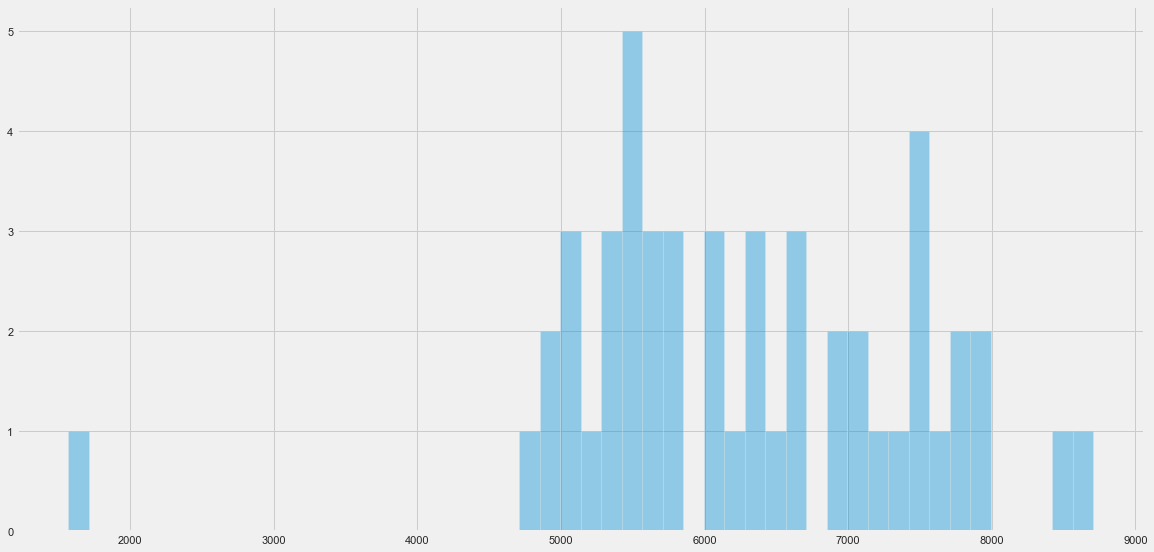

In [55]:
sns.distplot(list(presconf_script_chair_day_df['word_count']), bins=50, kde=False)

In [56]:
# # Check text
# print(presconf_script_chair_day_df['text'][0])

### Split contents to max 200 words

In [57]:
presconf_script_split_df = get_split_df(presconf_script_chair_day_df)
print(presconf_script_split_df.shape)
presconf_script_split_df.tail()


(2093, 13)


type       date                             title  \
2088  presconf_script 2021-07-28  FOMC Press Conference Transcript   
2089  presconf_script 2021-07-28  FOMC Press Conference Transcript   
2090  presconf_script 2021-07-28  FOMC Press Conference Transcript   
2091  presconf_script 2021-07-28  FOMC Press Conference Transcript   
2092  presconf_script 2021-07-28  FOMC Press Conference Transcript   

            speaker  word_count  decision  rate next_meeting  next_decision  \
2088  Jerome Powell         200         0   0.0          NaT           <NA>   
2089  Jerome Powell         200         0   0.0          NaT           <NA>   
2090  Jerome Powell         200         0   0.0          NaT           <NA>   
2091  Jerome Powell         200         0   0.0          NaT           <NA>   
2092  Jerome Powell         121         0   0.0          NaT           <NA>   

      next_rate  \
2088        NaN   
2089        NaN   
2090        NaN   
2091        NaN   
2092        NaN   

                                                                                                                                                                                                         text  \
2088  may be a little bit belowthat So the bigger picture is that you know that that that would be a healthy thing This is adifferent thing This is this is not that That was the kind of inflation we wer...   
2089  know there s there s absolutely no sense of panic I just I ve explained Ithink several times here today that the best my my best estimate is that this is something thatwill pass It s really a shoc...   
2090  and believe that we will react if if we need to And we will But again it s not it s not my base case My base case is that is as I ve saidrepeatedly is that inflation will move back down And no we ...   
2091  see there there is a form of wage inflation that canlead to price inflation and we re not seeing that right now And that really is if what we call unit labor costs move up and and and which really...   
2092  ofthe high inflationary era of the Great Inflation but it s not a feature now And we don t see thatnow Of course we ll be watching it And this is one of the reasons why we re watching so carefully...   

                                                                                                                                                                                                text_sections  \
2088  [Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us: maximum employment andprice stability.Today the Federal Open Ma...   
2089  [Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us: maximum employment andprice stability.Today the Federal Open Ma...   
2090  [Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us: maximum employment andprice stability.Today the Federal Open Ma...   
2091  [Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us: maximum employment andprice stability.Today the Federal Open Ma...   
2092  [Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us: maximum employment andprice stability.Today the Federal Open Ma...   

                                                                                                                                                                                                     org_text  
2088  CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed\rto achieving the monetary policy goals that Congress has given us: maximum employment and\rprice stability.\rToday ...  
2089  CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly comm

### Filter out by keywords

In [58]:
# Keep sections having keywords and long enough
presconf_script_keyword_df = remove_short_nokeyword(presconf_script_chair_day_df)
presconf_script_keyword_df.reset_index(drop=True, inplace=True)
print(presconf_script_keyword_df.shape)
presconf_script_keyword_df


(50, 13)


type       date                             title  \
0   presconf_script 2011-04-27  FOMC Press Conference Transcript   
1   presconf_script 2011-06-22  FOMC Press Conference Transcript   
2   presconf_script 2011-11-02  FOMC Press Conference Transcript   
3   presconf_script 2012-01-25  FOMC Press Conference Transcript   
4   presconf_script 2012-04-25  FOMC Press Conference Transcript   
..              ...        ...                               ...   
45  presconf_script 2021-01-27  FOMC Press Conference Transcript   
46  presconf_script 2021-03-17  FOMC Press Conference Transcript   
47  presconf_script 2021-04-28  FOMC Press Conference Transcript   
48  presconf_script 2021-06-16  FOMC Press Conference Transcript   
49  presconf_script 2021-07-28  FOMC Press Conference Transcript   

          speaker  word_count  decision  rate next_meeting next_decision  \
0    Ben Bernanke        3219         0   0.0   2011-06-22             0   
1    Ben Bernanke        2177         0   0.0   2011-08-01             0   
2    Ben Bernanke        2278         0   0.0   2011-11-28             0   
3    Ben Bernanke        4426         0   0.0   2012-03-13             0   
4    Ben Bernanke        2050         0   0.0   2012-06-20            -1   
..            ...         ...       ...   ...          ...           ...   
45  Jerome Powell        3145         0   0.0   2021-03-17             0   
46  Jerome Powell        2966         0   0.0   2021-04-28             0   
47  Jerome Powell        1828         0   0.0   2021-06-16             0   
48  Jerome Powell        3083         0   0.0   2021-07-28             0   
49  Jerome Powell        2180         0   0.0          NaT          <NA>   

    next_rate  \
0         0.0   
1         0.0   
2         0.0   
3         0.0   
4         0.0   
..        ...   
45        0.0   
46        0.0   
47        0.0   
48        0.0   
49        NaN   

                                                                                                                                                                                                       text  \
0   Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections al...   
1   Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and our policy strategy. ...   
2   Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your questions.As indica...   
3   Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and strategy. And finally...   
4   Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the context of our econom...   
..                                                                                                                                                                                                      ...   
45  Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us: maximum employment andprice stability. Since the beginning of th...   
46  Good afternoon. I would like to start by noting that it has been a fullyear since the pandemic arrived with force on our shores. Looking back, it was clear thataddressing a fast-moving global pand...   
47  Good afternoon. At the Federal Reserve, we are strongly committedto achieving the monetary policy goals that Congress has given us: maximum employment andprice stability.Today my colleagues on the...   
48  Good a

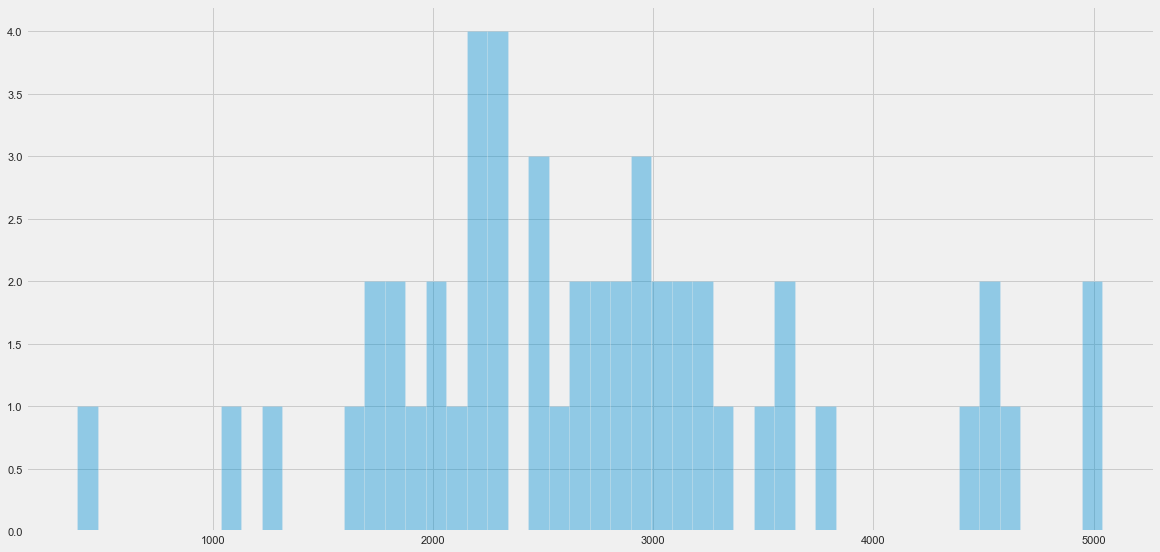

In [59]:
sns.distplot(list(presconf_script_keyword_df['word_count']), bins=50, kde=False)

In [60]:
# Drop text during the process to reduce the output size
presconf_script_chair_day_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Meeting Script DataFrame

In [61]:
# Sample
print(meeting_script_df['contents'][2])

--and we need a nomination.

[SECTION]

of the FOMC!

[SECTION]

CHAIRMAN VOLCKER.

[SECTION]

MR. PARTEE.

[SECTION]



[SECTION]

that way!

[SECTION]



[SECTION]

Chairman.

[SECTION]

Vice Chairman of the FOMC.

[SECTION]

date. Is there a second?

[SECTION]



[SECTION]

the nominees.

[SECTION]

That's the list, Mr. Chairman.

[SECTION]

plenitude of Davises--pardon me?

[SECTION]



[SECTION]

motion to that effect?

[SECTION]



[SECTION]

[reappointment them]?

[SECTION]



[SECTION]

have a motion?

[SECTION]



[SECTION]

CHAIRMAN VOLCKER.

[SECTION]



[SECTION]

since the last meeting, Mr. Pardee.

[SECTION]



[SECTION]

price of gold. Would that include any major commercial banks?

[SECTION]

past from the U.S. Treasury.

[SECTION]



[SECTION]

they can withstand such losses.

[SECTION]

dollar to go up in the face of that?

[SECTION]

bearish.

[SECTION]

of that?

[SECTION]

amounts.

[SECTION]

absence of intervention.

[SECTION]

[the dollar] has been pretty steady

In [62]:
# Reorganize the dataframe
proc_meeting_script_df = reorganize_df(meeting_script_df, 'meeting_script')


No rate decision found:  23
Shape of the dataframe:  (282, 13)


In [63]:
# Check the returned dataframe
proc_meeting_script_df

type       date                    title       speaker  \
0    meeting_script 1980-01-09  FOMC Meeting Transcript         other   
1    meeting_script 1980-02-05  FOMC Meeting Transcript         other   
2    meeting_script 1980-03-18  FOMC Meeting Transcript         other   
3    meeting_script 1980-04-22  FOMC Meeting Transcript         other   
4    meeting_script 1980-05-20  FOMC Meeting Transcript         other   
..              ...        ...                      ...           ...   
277  meeting_script 2014-06-18  FOMC Meeting Transcript  Janet Yellen   
278  meeting_script 2014-07-30  FOMC Meeting Transcript  Janet Yellen   
279  meeting_script 2014-09-17  FOMC Meeting Transcript  Janet Yellen   
280  meeting_script 2014-10-29  FOMC Meeting Transcript  Janet Yellen   
281  meeting_script 2014-12-17  FOMC Meeting Transcript  Janet Yellen   

     word_count  decision  rate next_meeting  next_decision  next_rate  \
0         45039      <NA>   NaN          NaT           <NA>        NaN   
1         39604      <NA>   NaN          NaT           <NA>        NaN   
2         23954      <NA>   NaN          NaT           <NA>        NaN   
3         21170      <NA>   NaN          NaT           <NA>        NaN   
4         24276      <NA>   NaN          NaT           <NA>        NaN   
..          ...       ...   ...          ...            ...        ...   
277       88988         0   0.0   2014-07-30              0       0.00   
278       90853         0   0.0   2014-09-17              0       0.00   
279       62779         0   0.0   2014-10-29              1       0.00   
280       74510         1   0.0   2014-12-17              0       0.00   
281       60091         0   0.0   2016-01-27              0       0.25   

                                                                                                                                                                                                        text  \
0    MR. STERNLIGHT.[SECTION]CHAIRMAN VOLCKER.securities] since when?[SECTION]MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79.[SECTION]CHAIRMA...   
1    CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out a memorandum onthe ...   
2    CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excuse me a moment. We havethe...   
3    CHAIRMAN VOLCKER.Can we come to order, ladies andgentlemen?I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us today. Welcometo your fi...   
4    CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.need to approve the minutes.[SECTION]MR. SCHULTZ.So moved.[SECTION]CHAIRMAN VOLCKER.[SECTION]MS. TEETERS.WeDo we have a second?Second.[SECTIO...   
..                                                                                                                                                                                                       ...   
277  CHAIR YELLEN. I’d like to begin by welcoming three people to the table today: StanFischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both Stan andLael, but both have ve...   
278  CHAIR YELLEN. Good morning, everybody. I would like to begin today’s meeting bygiving the floor to President Fisher, who asked if he could take a minute to address the group.[SECTION]MR. FISHER. T...   
279  CHAIR YELLEN. Good morning, everybody.Our first two items this morning will be conducted in a joint meeting between the FOMCand the Board. I need a motion to close the Board meeting.[SECTION]MR. F...   
280  CHAIR YELLEN. I’d like to call this meeting to order. Before turning to our agenda,I’d like to say a few words about our communications with the public. Many of you

In [64]:
# Check which row does not have rate
proc_meeting_script_df.loc[proc_meeting_script_df['rate'].isnull()]

type       date                    title speaker  word_count  \
0   meeting_script 1980-01-09  FOMC Meeting Transcript   other       45039   
1   meeting_script 1980-02-05  FOMC Meeting Transcript   other       39604   
2   meeting_script 1980-03-18  FOMC Meeting Transcript   other       23954   
3   meeting_script 1980-04-22  FOMC Meeting Transcript   other       21170   
4   meeting_script 1980-05-20  FOMC Meeting Transcript   other       24276   
..             ...        ...                      ...     ...         ...   
18  meeting_script 1982-02-02  FOMC Meeting Transcript   other       55066   
19  meeting_script 1982-03-30  FOMC Meeting Transcript   other       32658   
20  meeting_script 1982-05-18  FOMC Meeting Transcript   other       24541   
21  meeting_script 1982-07-01  FOMC Meeting Transcript   other       50094   
22  meeting_script 1982-08-24  FOMC Meeting Transcript   other       20096   

    decision  rate next_meeting  next_decision  next_rate  \
0       <NA>   NaN          NaT           <NA>        NaN   
1       <NA>   NaN          NaT           <NA>        NaN   
2       <NA>   NaN          NaT           <NA>        NaN   
3       <NA>   NaN          NaT           <NA>        NaN   
4       <NA>   NaN          NaT           <NA>        NaN   
..       ...   ...          ...            ...        ...   
18      <NA>   NaN          NaT           <NA>        NaN   
19      <NA>   NaN          NaT           <NA>        NaN   
20      <NA>   NaN          NaT           <NA>        NaN   
21      <NA>   NaN          NaT           <NA>        NaN   
22      <NA>   NaN          NaT           <NA>        NaN   

                                                                                                                                                                                                       text  \
0   MR. STERNLIGHT.[SECTION]CHAIRMAN VOLCKER.securities] since when?[SECTION]MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79.[SECTION]CHAIRMA...   
1   CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out a memorandum onthe ...   
2   CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excuse me a moment. We havethe...   
3   CHAIRMAN VOLCKER.Can we come to order, ladies andgentlemen?I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us today. Welcometo your fi...   
4   CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.need to approve the minutes.[SECTION]MR. SCHULTZ.So moved.[SECTION]CHAIRMAN VOLCKER.[SECTION]MS. TEETERS.WeDo we have a second?Second.[SECTIO...   
..                                                                                                                                                                                                      ...   
18  MESSRS. KICHLINE, ZEISEL, TRUMAN and PRELL.related charts--see Appendix.][Statements and[SECTION]CHAIRMAN VOLCKER. Do we have any comments or questions onhow these people see things?I have a quest...   
19  CHAIRMAN VOLCKER. We have some items to take care of at thebeginning of this meeting. First, the election of officers. We needto nominate a Chairman and a Vice Chairman in case you-MR. WALLICH. We...   
20  CHAIRMAN VOLCKER.I want to start off with a couple ofspecial items.The first item is welcoming Mrs. Horn to our littlegroup.This is going to be a slightly abnormal meeting for you, asyou will see ...   
21  CHAIRMAN VOLCKER. We can call the meeting to order and seekapproval of the minutes, if someone wants to propose that.[SECTION]MR. MARTIN.So moved.[SECTION]SPEAKER(?).Second.[SECTION]CHAIRMAN VOLCK...   
22  CHAIRMAN VOLCKER.the minutes?Would someone like to propose appr

(282, 13)


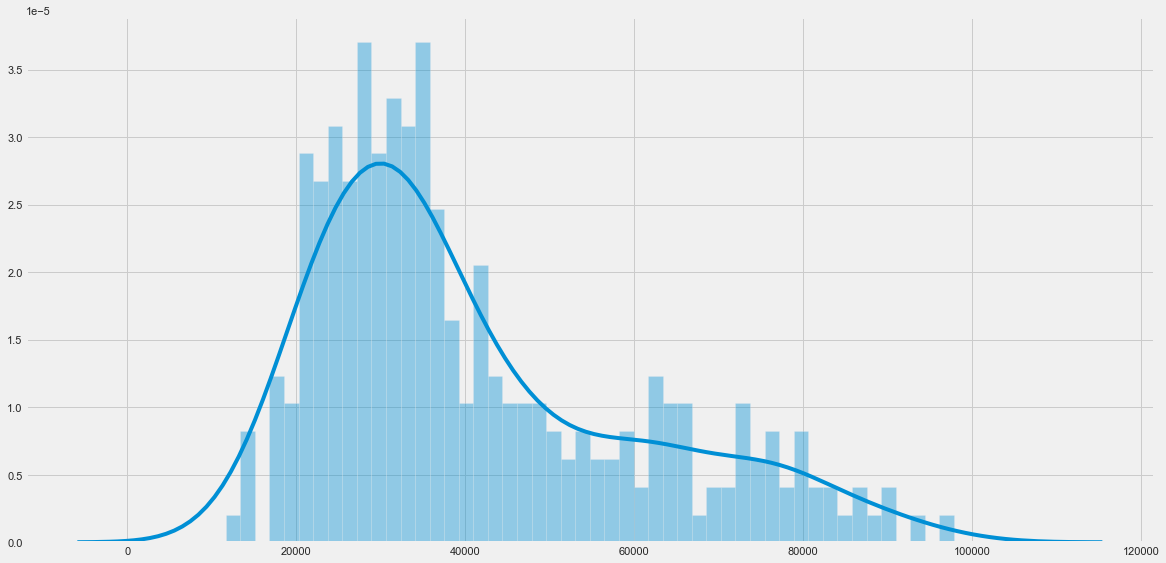

In [65]:
print(proc_meeting_script_df.shape)
sns.distplot(proc_meeting_script_df["word_count"].values, bins=50)

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [66]:
script_data_list = []

for i, row in tqdm(proc_meeting_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_meeting_script_df.columns

meeting_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
meeting_script_speaker_df

not matched:  MR. STERNLIGHT.
1980-01-09 00:00:00

not matched:  MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79.
1980-01-09 00:00:00

not matched:  MR. AXILROD.nonborrowed.He couldn't get in the total reserves.We fell short on total reserves, not on the
1980-01-09 00:00:00

not matched:  MR. PARTEE.I think that's probably right.
1980-01-09 00:00:00

not matched:  MR. AXILROD.[Yes], in looking at the uses of totalreserves. But if you really make it tough for yourself and analyzethis by looking at the sources of total reserves, as I think oneshould--if you think you're on a total reserve target, which theCommittee has not clearly said it's on, having said it's much more ona nonborrowed target--you would say that we fell short on the totalreserves in this three-week period simply because we didn't put inenough nonborrowed reserves to push up the total reserves to target.Of course, if we had put in nonborrowed reserves--given the 

not matched:  SPEAKER(?).are well above that.That's an average.So presumably half of them
1980-04-22 00:00:00

not matched:  MS. TEETERS.But it's a regional problem to some extent.
1980-04-22 00:00:00

not matched:  SPEAKER(?).Well, it will be heavily loaded with oil and gasloans, almost inevitably.
1980-04-22 00:00:00

not matched:  SPEAKER(?).In the second respect.
1980-04-22 00:00:00

not matched:  SPEAKER(?).Real estate loans have been very strong also.
1980-04-22 00:00:00

not matched:  SPEAKER(?).I'd look foolish.
1980-04-22 00:00:00

not matched:  SPEAKER(?).If our economic projections are correct, then weought to be phasing out this program in about two months anyway.
1980-04-22 00:00:00

not matched:  MR. BAUGHMAN(?).Well, I've gotten what I asked for.
1980-04-22 00:00:00

not matched:  SPEAKER(?).I don't want this analogy to sound too strange,but I think credit controls are little like the Vietnam war. We needto decide earlier rather than later to declare that we've won and p

1980-09-16 00:00:00

not matched:  MR. PARTEE.Larry, we're within the targets.
1980-09-16 00:00:00

not matched:  MR. SCHULTZ.It's a bit more toward "B."
1980-09-16 00:00:00

not matched:  MR. CORRIGAN.That's my problem.Yes, but we don't have much room for error.
1980-09-16 00:00:00

not matched:  MR. PARTEE.But we were below the ranges._
1980-09-16 00:00:00

not matched:  MS. TEETERS.But we're within them.
1980-09-16 00:00:00

not matched:  MR. WALLICH.You're not including August?
1980-09-16 00:00:00

not matched:  MR. GRAMLEY.
1980-09-16 00:00:00

not matched:  MR. PARTEE.something like that.
1980-09-16 00:00:00

not matched:  MR. AXILROD.
1980-09-16 00:00:00

not matched:  MR. PARTEE.Okay, thank you.It's really a $700 to $800 million range, orYes.That's a better way to think of it.
1980-09-16 00:00:00

not matched:  MR. ALTMANN.Chairman VolckerVice Chairman SolomonGovernor GramleyPresident GuffeyPresident MorrisGovernor ParteeGovernor RicePresident RoosGovernor SchultzGovernor Teete

not matched:  MR. KICHLINE.To 6-1/2 percent?Yes, to 6-1/2 percent in the fourth quarter of1982.
1981-02-03 00:00:00

not matched:  MR. PARTEE.What is that nominal GNP?
1981-02-03 00:00:00

not matched:  MR. WALLICH.I believe they raised the interest rate levellately.
1981-02-03 00:00:00

not matched:  MR. ROOS.Is it feasible to ask the staff to take this tableon page 6 and run off a little supplementary table we can use based onwhatever we are going to talk about tomorrow?
1981-02-03 00:00:00

not matched:  MR. WALLICH.Isn't base drift from the midpoint and not fromthe edge?
1981-02-03 00:00:00

not matched:  MR. AXILROD.Just make that table for M-1A and M-1B?
1981-02-03 00:00:00

not matched:  MR. AXILROD.Yes, I think that's all.It's very simple.-102-2/2-3/81
1981-02-03 00:00:00

not matched:  MR. AXILROD.I'm sure the public will very easily grasp
1981-02-03 00:00:00

not matched:  MR. SCHULTZ.I think it is clear.this!
1981-02-03 00:00:00

not matched:  MR. MAYO.That's right.
1981-02


not matched:  MS. TEETERS.
1981-07-07 00:00:00

not matched:  MR. BALLES.What do you get for real growth and inflation?We get more real growth and less inflation.What money supply do you get?We're using the same assumptions as the Board'smodel.
1981-07-07 00:00:00

not matched:  MR. BALLES.
1981-07-07 00:00:00

not matched:  MR. FORD.That's the key to it.
1981-07-07 00:00:00

not matched:  MR. AXILROD.About[unintelligible] percent velocity.
1981-07-07 00:00:00

not matched:  MR. PARTEE.And will continue.
1981-07-07 00:00:00

not matched:  MR. BALLES.And will continue.
1981-07-07 00:00:00

not matched:  MR. PARTEE.So, you're not that far from Bill.
1981-07-07 00:00:00

not matched:  MR. MORRIS.They're going toI think M2 is too narrow, too.
1981-07-07 00:00:00

not matched:  MR. PARTEE.You wouldn't?
1981-07-07 00:00:00

not matched:  MR. CORRIGAN.No.
1981-07-07 00:00:00

not matched:  MR. ROOS.Is this in addition to [the forecasts] we wiredin?
1981-07-07 00:00:00

not matched:  MR. PART


not matched:  MS. TEETERS.Don't you have M2 growth too low?
1981-11-17 00:00:00

not matched:  MR. PARTEE.I didn't have the Bluebook open right there.think 10-1/2 percent is about-MS. TEETERS.I11-1/4 percent is--
1981-11-17 00:00:00

not matched:  MR. CORRIGAN.I didn't say it very well, Governor Partee,but that's the gist of what I was trying to say before.
1981-11-17 00:00:00

not matched:  MR. PARTEE.I really don't think this is a good month to tryto reform the way we state the directive. It's in the middle of aquarter, as you said before; it's at the end of a year; and it's in aperiod where we're going to fall short of our growth for the year as awhole. And we just shouldn't be doing fancy things with the directiveright now. If we want to do it, we can do it in January and start outa new year with a-CHAIRMAN VOLCKER. But we don't have this kind of problem infor which we have no targets.So, we don't have the problem.
1981-11-17 00:00:00

not matched:  MR. PARTEE.I don't think we pre


not matched:  MS. TEETERS.saving rate?How would you feed back the change in the
1982-02-02 00:00:00

not matched:  MR. PARTEE.It is very fuzzy.
1982-02-02 00:00:00

not matched:  MR. CORRIGAN.I don't know; frankly, I am very troubled atthe prospect of opening up this rebasing issue and changing the M2target.I think Governor Schultz is right on the mark on thisquestion. The issue, as Governor Teeters suggests, is gettingunemployment down and all the rest, but not for a quarter or two.Theissue in some sense is trying to be supportive of a sound approach tofiscal policy. But we are sitting here looking at a fiscal situationthat is just untenable. And one of the concerns I have--and maybe itis tilting at our windmills a little--is that if the perception isthat we really are easing, any prospect of being able to do better onthe fiscal side is weakened as well because that creates theimpression that we are going to sit here and monetize all that debt.I am under no illusion that we are going

1982-07-01 00:00:00

not matched:  MS. TEETERS.It would be useful to get some of the attentionaway from where we actually end up in the final quarter or the finalmonths of the year because making it precisely in those time frames, Ithink, is a fallacious target.
1982-07-01 00:00:00

not matched:  MR. PARTEE.seriously this year.But we never looked at the midpoint that
1982-07-01 00:00:00

not matched:  MS. TEETERS.Well, wait Jerry, we're just building up aprecedent that we never change the ranges.
1982-07-01 00:00:00

not matched:  MR. CORRIGAN.No, I think this time it works the other way.
1982-07-01 00:00:00

not matched:  MS. TEETERS.Yes, but then it seems to me we should go back,say, in August or September and change the range.
1982-07-01 00:00:00

not matched:  MS. TEETERS.Yes, but we're still going to run into the endof-the-year problem with everybody expecting us to try to reducemonetary growth.
1982-07-01 00:00:00

not matched:  MR. CORRIGAN.This year?
1982-07-01 00:00:00

not ma

not matched:  MR. PARTEE.I didn't think you'd ever say that, Lyle.
1982-11-16 00:00:00

not matched:  MR. MORRIS.the Martin years.And we'd get to the point where we were back in
1982-11-16 00:00:00

not matched:  MR. MORRIS.an awful lot left!
1982-11-16 00:00:00

not matched:  MR. PARTEE.If you eliminate both of those, you don't haveYou have the--
1982-11-16 00:00:00

not matched:  MS. TEETERS.I can't foresee that we're going to make anyradical change, even as much as 2 or 3 percentage points, at any givenmeeting. Even when we targeted interest rates, I think the most weever moved [the funds rate] was 1/4 to 1/2 percentage point.[Undercurrent procedures] we've been moving it a percentage point in a 400basis point range. We gradually move them up and down; I don't seethat we're going to get major market shocks or anything of that sort.We did have one major market shock and that occurred when we changedto reserve targeting and a [wide] band on the interest rate target.And the market surv

not matched:  MR. WALLICH.uncertain, but I would refer to the longer-term ranges and say if theactual numbers fall significantly below most of those and we have aBut if theycollapse in the aggregates then, yes, [we would ease].are just more or less in the ballpark, I would want easing precluded.
1983-02-09 00:00:00

not matched:  MR. PARTEE.We could do that; it makes sense.
1983-02-09 00:00:00

not matched:  MR. PARTEE.It's a question of under what conditions would
1983-02-09 00:00:00

not matched:  SPEAKER(?).I'm not sure.we ease.
1983-02-09 00:00:00

not matched:  MS. TEETERS.But M3 is being affected by the growth rate inM2 also.
1983-02-09 00:00:00

not matched:  MR. MORRIS.for M3.But relatively little.
1983-02-09 00:00:00

not matched:  MR. WALLICH.If we referto the totality of our many targetsin a broad way so that M2 can be seen as being exempted if necessary,one gets a sense of what I think we ought to aim at amongst theaggregates.
1983-02-09 00:00:00

not matched:  MR. MORRIS.s

not matched:  MR. BALLES.
1983-07-13 00:00:00

not matched:  MR. BLACK.-35-Yes, it is.Alternative III makes a lot of sense.Nobody says it's the level of--
1983-07-13 00:00:00

not matched:  MR. BOEHNE.
1983-07-13 00:00:00

not matched:  MR. BLACK.That's a little peculiar.Yes.And it moves the midpoint only 1/4 of a point.
1983-07-13 00:00:00

not matched:  MR. RICE.expansion.
1983-07-13 00:00:00

not matched:  MR. BLACK.
1983-07-13 00:00:00

not matched:  MR. MORRIS.
1983-07-13 00:00:00

not matched:  MR. RICE.
1983-07-13 00:00:00

not matched:  MR. PARTEE.Except that I'm not worried about a rapidWhat would you--?Some people are worried about a rapid expansion.Some people.Do we want to raise the bottom and leave the topthe same?
1983-07-13 00:00:00

not matched:  MR. AXILROD.No, that's right; I miscalculated or something.
1983-07-13 00:00:00

not matched:  MR. WALLICH.
1983-07-13 00:00:00

not matched:  MS. TEETERS.term trend before.That is, I think, the logic of the situation.We haven'

not matched:  MR. MORRIS.
1983-11-15 00:00:00

not matched:  MR. PARTEE.How about May of 1975?
1983-11-15 00:00:00

not matched:  MS. TEETERS.
1983-11-15 00:00:00

not matched:  MR. RICE.We tightened because the aggregates went up.
1983-11-15 00:00:00

not matched:  MR. PARTEE.
1983-11-15 00:00:00

not matched:  MR. RICE.How about May of 1983?To no avail.
1983-11-15 00:00:00

not matched:  MR. GRAMLEY.Five percent Ml?
1983-11-15 00:00:00

not matched:  MR. GRAMLEY.I'm talking about next year.That isn't what the staff is projecting fornext year.
1983-11-15 00:00:00

not matched:  MR. GRAMLEY.like?lookpercent
1983-11-15 00:00:00

not matched:  MR. PARTEE.I don't care what the staff is predicting;Yes, but if 5 percent looks high, what does 7Very high!
1983-11-15 00:00:00

not matched:  MR. WALLICH.the economy."We could say "further evidence of strength in
1983-11-15 00:00:00

not matched:  MR. GRAMLEY.
1983-11-15 00:00:00

not matched:  MR. PARTEE.That sounds good to me.And then pick up t

not matched:  MR. GRAMLEY.I was going to offer a series of numbers, butnow with that stipulation--.
1984-03-27 00:00:00

not matched:  MR. PARTEE.I think they look pretty good.
1984-03-27 00:00:00

not matched:  MR. PARTEE.pretty happy.If we don't take them too seriously,If we could actually come out there, I'd be
1984-03-27 00:00:00

not matched:  MR. BOYKIN.I would prefer 6, 7-1/2, and 8 percent, Mr.Chairman.
1984-03-27 00:00:00

not matched:  MR. GRAMLEY.I would go with Bob.-77-3/26-27/84
1984-03-27 00:00:00

not matched:  MS. HORN.I'll go with that.
1984-03-27 00:00:00

not matched:  MS. HORN.Lead off with 7-1/2 and 8 percent, not 6 percent.
1984-03-27 00:00:00

not matched:  MR. PARTEE.It's symmetrical.
1984-03-27 00:00:00

not matched:  MR. MARTIN.Somewhat.Well, I guess it's slightly asymmetricalSomewhat.
1984-03-27 00:00:00

not matched:  MS. TEETERS.It's notbegin to get all sorts of volatility in interest rates.worth the price.
1984-03-27 00:00:00

not matched:  MR. CORRIGAN.I

1984-10-02 00:00:00

not matched:  MR. PARTEE.I don't know why it shouldn't be.I considerthe home currency to be the dollar rather than the mark!
1984-10-02 00:00:00

not matched:  MR. PARTEE.Well, I don't remember the basis for doing itthis way.
1984-10-02 00:00:00

not matched:  MR. MARTIN.
1984-10-02 00:00:00

not matched:  MR. CROSS.I'm perfectly happy to.I certainly support that.I would welcome an increase of $1 billion.
1984-10-02 00:00:00

not matched:  MR. MARTIN.Not at German interest rates or[rates on]Let's hope not.
1984-10-02 00:00:00

not matched:  MR. CROSS.Well, it would be $6-1/2 billion.$6-1/2 billion and raise the total for all ofthem?
1984-10-02 00:00:00

not matched:  MR. CROSS.to consider it, would be to keep the informal limit on the total butto eliminate this difference between how much is in DM and how much isThatin yen, and how much is in Swiss francs and other currencies.would provide a little more flexibility.
1984-10-02 00:00:00

not matched:  MR. CROSS.I wo

1985-02-13 00:00:00

not matched:  MR. GRAMLEY.
1985-02-13 00:00:00

not matched:  MR. BLACK.It will become known as the Volckergram.With a truncated band.
1985-02-13 00:00:00

not matched:  MR. PARTEE.A little flatter.
1985-02-13 00:00:00

not matched:  MR. WALLICH.
1985-02-13 00:00:00

not matched:  MR. PARTEE.Right.Probably 1 percent flatter.
1985-02-13 00:00:00

not matched:  MR. BALLES.I'd settle for that.
1985-02-13 00:00:00

not matched:  MR. BLACK.Right.-61-2/12-13/85
1985-02-13 00:00:00

not matched:  MR. PARTEE.Target.
1985-02-13 00:00:00

not matched:  MR. BLACK.Yes, that's what I understood you to say.
1985-02-13 00:00:00

not matched:  MR. WALLICH.It creates lots of room, all right.It sure does.
1985-02-13 00:00:00

not matched:  MR. AXILROD.Yes, it's more than with parallel lines.
1985-02-13 00:00:00

not matched:  MR. PARTEE.M1 is right after the full page of tables.
1985-02-13 00:00:00

not matched:  MR. MARTIN.Two pages beyond page 10.
1985-02-13 00:00:00

not matched

1985-08-20 00:00:00

not matched:  MR. PARTEE.
1985-08-20 00:00:00

not matched:  MR. BLACK(?).
1985-08-20 00:00:00

not matched:  MR. RICE(?).It takes a small fourth quarter to do that.It sure does;it's moving away.He doesn't give it a very high probability.-31-8/20/85
1985-08-20 00:00:00

not matched:  MR. BOYKIN.I would also look at "B," obviously for all thereasons that have been stated. My tilt--and it would be a very slighttilt--would be toward "C," which would be a very slight increase.Ido have concern about the credibility problem; what is happening to M1I think some stability, if youis extremely difficult to explain.will, in interest rates would not be bad.I start getting a littlenervous when I hear words that seem to say that we need to peg the fedfunds rate.I get uncomfortable with that.That would not be theobjective, but some stability would be good. Borrowings of about $450million would be all right with me.
1985-08-20 00:00:00

not matched:  MS. SEGER.I was thinking abou

1986-02-12 00:00:00

not matched:  MS. SEGER.I just want to take one minute to bore you withsome ancient history.I was looking at some of the numbers that welooked at a year ago and, at that point, we had seen a surprisingly2/11-12/86strong performance of real GNP in the fourth quarter. At the time ofthe December FOMC meeting we had been expecting real GNP growth of 1.3percent.Lo and behold, it came in at 3.9 percent--or the Greenbookwas showing 3.9 percent for the 4th quarter of 1984. As I recall, ourreaction to this was somewhat like I sense our reaction is today tothe strong employment numbers: Fasten your seat belts, we are about totake off. As I look back at 1985, other than that big expectation atthe beginning of the year, I didn't see much of a takeoff.I read thenumbers as a rather sluggish performance; I think real GNP growth forthe year was something like 2-1/2 percent.I just mention thatbecause I think it suggests that we can put too much emphasis on acurrent number and sort

not matched:  MR. RICE.You could certainly buy a couple of hundredmillion.
1986-09-23 00:00:00

not matched:  MR. MORRIS.If the Treasury doesn't object, it seems to methat would be the answer. You could have your cake and eat it too.9/23/86
1986-09-23 00:00:00

not matched:  MR. RICE.To keep people from being surprised.
1986-09-23 00:00:00

not matched:  MR. ANGELL.It seems to me that if we do not want to sell,and that presumably is the consensus, we ought not to buy as long-termas we've been buying. That would maintain more liquidity. If you cannever sell then there is merit in shortening the maturities that youdo buy.But presumably we learn something about the
1986-09-23 00:00:00

not matched:  MR. MORRIS.functioning of the long-term market by seeing a response to ourI assume that's where Peter-operations.
1986-09-23 00:00:00

not matched:  MR. MORRIS.It's not a matter of oiling the machinery; it'sreally having a test that we participate in to see how the machineryis working.
1986-0

not matched:  MR. KOHN.Okay.Mr. Kohn, can you be fast?[Statement--see Appendix.][Coffee break]
1987-03-31 00:00:00

not matched:  MR. JOHNSON.I think they are too high if interest ratespick up.
1987-03-31 00:00:00

not matched:  CHAIRMANto date, Mr. Kohnlittle lower thanpercent, I guess,
1987-03-31 00:00:00

not matched:  MR. KOHN.
1987-03-31 00:00:00

not matched:  MR. GUFFEY.Thank you, Mr. Chairman.I think Jerry Corrigancaptured my feelings very well.That is, I would favor no immediatechange in policy but I would be prepared to move to a higher borrowinglevel. Having that in mind, and trying to capture that within theframework of the way we talk about these things, that is somewhere inthe "B-C" area.I'm not sure that I would be prepared to go to $500million. On the other hand, I feel that there may be some advantageto showing some modestly higher interest rates earlier rather thanlater--that is, to permit the market to understand that somewhathigher interest rates effected by the Fed

1987-09-22 00:00:00

not matched:  MR. JOHNSON.
1987-09-22 00:00:00

not matched:  SPEAKER(?).Sure.Well, Peter's skills will take care of that.Good.
1987-09-22 00:00:00

not matched:  MR. STERNLIGHT.I haven't been very good.
1987-09-22 00:00:00

not matched:  MR. BERNARD.Chairman GreenspanVice Chairman CorriganGovernor AngellPresident BoehnePresident BoykinGovernor HellerGovernor JohnsonPresident KeehnGovernor KelleyGovernor SegerPresident SternYesYesYesYesYesYesYesYesYesYesYes
1987-09-22 00:00:00

not matched:  END OF MEETING
1987-09-22 00:00:00

not matched:  MR. CROSS.[Statement--see Appendix.]
1987-11-03 00:00:00

not matched:  MR. BOEHNE.Mr. Cross. A week ago, we were talking about walking a thin linebetween the dollar and the domestic economy and I get the feeling thatHow wide isthat thin line has broadened out some since a week ago.it and do we have a policy or don't we have a policy?Is it theTreasury that's making U.S. policy or are we just kind of letting theto go with the dol

not matched:  MR. GUFFEY.
1988-03-29 00:00:00

not matched:  MR. JOHNSON.that chart.Well-That's all right.I'd rather do it that way.Yes, well, that's what I was talking about.Yes.But that's a lot of phone calls, if you look at
1988-03-29 00:00:00

not matched:  MR. GUFFEY.In 1985?
1988-03-29 00:00:00

not matched:  MR. HELLER.Yes.
1988-03-29 00:00:00

not matched:  MR. HELLER.
1988-03-29 00:00:00

not matched:  MS. SEGER.And they're plotted here as official changes?Yes.-32-3/29/88
1988-03-29 00:00:00

not matched:  MR. JOHNSON.official change.Yes, everything on that solid line is anEverything was--
1988-03-29 00:00:00

not matched:  MR. GUFFEY.But how can you have an official change without
1988-03-29 00:00:00

not matched:  MR. HELLER.a vote being taken?I asked him;
1988-03-29 00:00:00

not matched:  MR. HELLER.Oh, I see.
1988-03-29 00:00:00

not matched:  MR. KOHN.everyEvery change in the borrowings levelYes.
1988-03-29 00:00:00

not matched:  MR. JOHNSON.Yes; that's what a policy c

not matched:  MR. MORRIS.I guess that's right.Yes.
1988-11-01 00:00:00

not matched:  MR. KOHN.[Statement--see Appendix.]
1988-11-01 00:00:00

not matched:  MR. HELLER.affect the--How about the takeover activity, how does that
1988-11-01 00:00:00

not matched:  MR. HELLER.Thanks.
1988-11-01 00:00:00

not matched:  MR. JOHNSON.I agree with a lot of what you said about that, but with thatprices.kind of increase in real disposable income, it might have an effect ondemand that you wouldn't necessarily want to validate fully. However,that still may mean that nominal rates would fall, even though you'resaying that you wouldn't let real interest rates come down as much.
1988-11-01 00:00:00

not matched:  MR. HELLER.Thanks.
1988-11-01 00:00:00

not matched:  MR. ANGELL.President Melzer.You support borrowing of $600 million?
1988-11-01 00:00:00

not matched:  MR. PARRY.That seems to raise a lot of issues.
1988-11-01 00:00:00

not matched:  MR. BLACK.Well, it's been the day to do things.
1988-11

not matched:  MR. MELZER.In terms of the outlook, our money-driven modelends up with a pattern very similar to the Board staff's forecast--inother words, slowing real growth and inflation leveling off over thisyear-and-a-half period. The main difference is on the real side wherewe have considerably weaker real growth--roughly 1-1/2 percent forthis year as a whole and 1 percent for next year. But in terms of thedeflator our numbers are within a tenth or two of what the Board staffhas.The only other thing to mention is that our forecast assumes, asdoes the Board staff forecast, a reacceleration in money growth in thesecond half of this year and continuing on in the next year.As far as the District is concerned, our numbers show thisNoncontinuing pattern of slowing that has been mentioned.agricultural employment growth is slower than the national average.It's interesting that even though the unemployment rate is coming downthe District rate is still somewhat higher, at around 6.2 percent.

not matched:  MR. JOHNSON.I was just quoting the numbers ex-food andIf you look at the totals it's not quite as clear.
1989-11-14 00:00:00

not matched:  MR. HOSKINS.Don't let that stop you!
1989-11-14 00:00:00

not matched:  MR. KELLEY.Along with mine.
1989-11-14 00:00:00

not matched:  MR. HOSKINS.I'd like you to talk a little about why wedon't have an alternative C.It surprises me that the risks ofrecession clearly dominate the staff thinking relative to the risks ofinflation. Another way to say that is that to me it looks likeFederal Reserve policy is designed to prevent the inflation rate fromfalling.
1989-11-14 00:00:00

not matched:  MR. SYRON.I agree with your suggestion basically becauseGiven what we did last week, I don't think we haveit's no change.much choice right now. I think we're in a very difficult situation.As Ed Boehne said, it is a question of risks; and I agree with TomMelzer's point that some reality testing has to be done out there andI'm not quite sure how we ge

not matched:  MR. LAWARE.That's why I'm saying IGovernor LaWare."B" symmetric.
1990-05-15 00:00:00

not matched:  MR. ANGELL.I'm somewhat tempted, Mr. Chairman, tocounterbalance by having a governor vote for tightness to offset Mr.Hoskins' dissent so that we don't continue this issue about presidentsversus governors on the tightening side. But I guess that reallywouldn't be a logical basis for me to cast my vote.I would note thatof the presidents who are voting only two out of five of them couldmuster a tightness in their [policy stance].But of the ones who arenot voting, four out of five can muster tightness, which I thinkprobably is what gives the presidents the reputation for being hawks.You presidents really are hawks when you don't have a vote!
1990-05-15 00:00:00

not matched:  MR. ANGELL.It seems to me, Mr. Chairman, that you arecorrect that there is some uncertainty right now. And thatuncertainty is such that, even though I'm in the mood to tighten and Iwas hoping we would be t

not matched:  MR. PRELL.
1991-02-06 00:00:00

not matched:  MR. MELZER.
1991-02-06 00:00:00

not matched:  MR. KOHN.That's the incremental amount, Mike?Yes, incremental M2 growth in 1991.To bring it up to a total of what, Mike?Seven percent.
1991-02-06 00:00:00

not matched:  MR. HOSKINS.The District's [economic] activity has softenedsince October but is still generally stronger than the nation's.Theunemployment rate in Ohio is up about 1/2 point but employment isabout the same; it hasn't changed much. In fact, if you look at[initial unemployment] claims, the peak seems to be in the first weekof January at 44,000 and they declined gradually each week to around2/5-6/91-32-24,000. The hardest hit, of course, are autos and auto-relatedindustries; that has impacted steel companies, which are operating atabout 70 percent. [Unintelligible] cited a recent survey by a bank ofits customers and 85 percent of respondents said that in terms of newprojects they have no trouble getting credit; in t

not matched:  MR. LAWARE.I would prefer "B" with symmetric language.Ireally think that we have to send a firm sign that the [downwardinterest rate] drift is going to stop.That could have a verystimulating effect because I think the economy and the public arebeing exposed to something akin to Chinese water torture. We creepdown 1/4 point in the funds rate and then we creep down another 1/4point and we change the discount rate.If we follow that samepattern, it seems to me that we are creating the expectation that thatpattern is going to continue almost indefinitely.I think there's alot to be said for turning it off, at least for a while, and seeingwhat happens.I'm still not convinced that all of the effects of ourprevious easings have come through and I don't see why we need tocontinue this drift.So, I would be in favor of "B" symmetrical.12/17/91-37-
1991-12-17 00:00:00

not matched:  MS. PHILLIPS.I also am pleased to support the proposal.could have gone further, but I'm happy to suppo

not matched:  MR. JORDAN.I've met with a number of people throughout theDistrict in recent weeks, and the general sense is that our area ofthe country is now fully recovered from the 1982 recession.10/6/92-36-[Laughter]We didn't experience the 1990-91 one.Employment growthhas been better than the nation; industrial production has been betterthan for the nation; jobs are up about 1-1/2 percent since thebeginning of the year. The unemployment rate hasn't come down as muchbecause labor force growth is very strong. Other people following mecould be moving back from southern California to the Midwest.In manyrespects it's somewhat of a reversal of what we saw in the '85-'89period when I was out West.We have a large number of major national retail organizationsheadquartered in the District.In talking with them they say thismonths, and better than they [had first] thought.There was a biggerpickup in sales post Labor Day.We're running retail sales increasesin our District of about 6-1/2 percen

not matched:  MR. KOHN.job communicating.Well, I think the Chairman has done a very good
1993-07-07 00:00:00

not matched:  MR. ANGELL.Are you arguing for alternative III rather thanII?
1993-07-07 00:00:00

not matched:  MR. ANGELL.still undershoot?Do you have any concern if we go to II and then
1993-07-07 00:00:00

not matched:  MR. ANGELL.No, I'm arguing for II.Sure, and then we go to III.Okay.
1993-07-07 00:00:00

not matched:  MR. FORRESTAL.Are you talking about 1993 or 1994?
1993-07-07 00:00:00

not matched:  MR. ANGELL.Sure.
1993-07-07 00:00:00

not matched:  MR. BROADDUS.[of credibility] in affectingWe'll have to take another step, I guess.
1993-07-07 00:00:00

not matched:  MR. PARRY.It may beconstructive thento say:By theway,this range is probably pretty much consistent with that and reasonableprice stability as well.
1993-07-07 00:00:00

not matched:  MR. LINDSEY.widespread view--You've just disturbed your colleague toIn that case, and I do think that's a
1993-07-07 00:00:00


1994-02-04 00:00:00

not matched:  MR. LINDSEY.
1994-02-04 00:00:00

not matched:  MR. PRELL.I've not seen them, but there are lots of data inthis area; perhaps they have them at the Bureau of the Census.
1994-02-04 00:00:00

not matched:  MR. LINDSEY.
1994-02-04 00:00:00

not matched:  MR. LINDSEY.Okay.
1994-02-04 00:00:00

not matched:  MR. PRELL.I think we have about .3 percent for January.
1994-02-04 00:00:00

not matched:  MR. STOCKTON.
1994-02-04 00:00:00

not matched:  MR. PRELL.What estimate are you using internallyAnd the core?It's .4 percent for the total CPI.And .3 percent for the core.
1994-02-04 00:00:00

not matched:  MR. SYRON.Right.
1994-02-04 00:00:00

not matched:  MR. PRELL.
1994-02-04 00:00:00

not matched:  MR. SYRON.that--thank you.Right.But I was just wondering whether independent of
1994-02-04 00:00:00

not matched:  MR. LAWARE.
1994-02-04 00:00:00

not matched:  MR. LAWARE.Yes!
1994-02-04 00:00:00

not matched:  MS. PHILLIPS.You gave the right answer?[Laughter]

not matched:  MR. FISHER.Yes, a year from now.
1994-11-15 00:00:00

not matched:  MR. BOEHNE(?).
1994-11-15 00:00:00

not matched:  SPEAKER(?).Move approval.Second.
1994-11-15 00:00:00

not matched:  MR. BERNARD:Chairman GreenspanVice Chairman McDonoughGovernor BlinderPresident BroaddusPresident ForrestalPresident JordanGovernor KelleyGovernor LaWareGovernor LindseyPresident ParryGovernor PhillipsGovernor Yellento lunch?
1994-11-15 00:00:00

not matched:  SPEAKER(?).ApproveApproveApproveNoApproveApproveApproveApproveApproveApproveApproveApproveWould somebody like to move that we goNo objection.
1994-11-15 00:00:00

not matched:  END OF MEETING
1994-11-15 00:00:00

not matched:  SPEAKER(?).Second.
1994-12-20 00:00:00

not matched:  MR. FISHER.Thank you.
1994-12-20 00:00:00

not matched:  MS. LOVETT.Appendix.][Statement--See Appendix.]Questions for Peter?Thank you, Mr. Chairman.
1994-12-20 00:00:00

not matched:  MS. LOVETT.It has been a disappointing year for a lot ofpeople in the finan

not matched:  MS. MINEHAN.But that is not the demand shock that you hadin mind?
1995-07-06 00:00:00

not matched:  MR. KOHN.In terms of a trend interest rate?7/5-6/95
1995-07-06 00:00:00

not matched:  MR. BLINDER.Thank you.
1995-07-06 00:00:00

not matched:  MR. BOEHNE.In my view, Mr. Chairman, that is both anaccurate and a sensible statement. There is a dog over in the cornerand he is asleep and his name is Aggregates and we ought to let himsleep for another year or two.
1995-07-06 00:00:00

not matched:  MS. PHILLIPS.I favor alternative II for 1995 andalternative I for 1996.I find myself quite frustrated with thisdiscussion. I think part of it has to do with our not really knowingwhether the ranges are something we should be shooting for--whetherthey are long-term objectives, or whether they are in effect shortterm monitoring ranges to be explained. So, I support the notion ofhaving a more extended discussion of what our goals should be in termsof thinking about restructuring the H

not matched:  SPEAKER(?)I move approval.Second.
1996-07-03 00:00:00

not matched:  MR. TRUMAN.Well, as you probably know better than I, everytime we have looked at North Sea production over the last 10 years, itwas going to diminish in 2 years. The people who look at this, andthey include the experts of the International Energy Agency, expectthat Norwegian production will level off at a peak level in 1997 andthen decline.That is, of course, one of the reasons why we don't getthe same non-OPEC supply coming on stream as in recent years. That isthe logic. New discoveries and new techniques obviously could lead tomore production than we now assume, but that remains to be seen.
1996-07-03 00:00:00

not matched:  MR. TRUMAN.more cheating.Yes.
1996-07-03 00:00:00

not matched:  MR. PARRY.Thank you.
1996-07-03 00:00:00

not matched:  MR. LINDSEY.But your added constraint certainly isn't --
1996-07-03 00:00:00

not matched:  MR. PRELL.Roughly.
1996-07-03 00:00:00

not matched:  MR. JORDAN.Mike

not matched:  MR. BERNARD.Chairman GreenspanVice Chairman McDonoughPresident BroaddusPresident GuynnGovernor KelleyGovernor MeyerPresident MoskowPresident ParryGovernor PhillipsGovernor RivlinYesYesYesYesYesYesYesYesYesYes
1997-09-30 00:00:00

not matched:  END OF MEETING
1997-09-30 00:00:00

not matched:  SPEAKER(?). Second.
1997-11-12 00:00:00

not matched:  MR. BERNARD.Chairman GreenspanVice Chairman McDonoughPresident BroaddusGovernor FergusonGovernor GramlichPresident GuynnGovernor KelleyGovernor MeyerPresident MoskowPresident ParryGovernorPhillipsGovernor RivlinYesYesNoYesYesYesYesYesYesYesYesYes11/12/97104
1997-11-12 00:00:00

not matched:  END OF MEETING
1997-11-12 00:00:00

not matched:  SPEAKER(?). Neither won!
1997-12-16 00:00:00

not matched:  MR. BERNARD.Chairman GreenspanVice Chairman McDonoughPresident BroaddusGovernor FergusonGovernor GramlichPresident GuynnGovernor KelleyGovernor MeyerPresident MoskowPresident ParryGovernor PhillipsGovernor RivlinYesYesNoYesYesYesYesY

not matched:  MR. BERNARD.Chairman GreenspanVice Chairman McDonoughPresident BoehneGovernor FergusonGovernor GramlichGovernor KelleyPresident McTeerGovernor MeyerPresident MoskowGovernor RivlinPresident SternYesYesYesYesYesYesYesYesYesYesYes
1999-05-18 00:00:00

not matched:  END OF MEETING
1999-05-18 00:00:00

not matched:  MR. BERNARD.Chairman GreenspanVice Chairman McDonoughPresident BoehneGovernor FergusonGovernor GramlichGovernor KelleyPresident McTeerGovernor MeyerPresident MoskowPresident SternYesYesYesYesYesYesYesYesYesYes
1999-06-30 00:00:00

not matched:  SPEAKER(?). That’s a good answer.
1999-06-30 00:00:00

not matched:  MR. BERNARD.Chairman GreenspanVice Chairman McDonoughPresident BoehneGovernor FergusonGovernor GramlichGovernor KelleyPresident McTeerGovernor MeyerPresident MoskowPresident SternYesYesYesYesYesYesNoYesYesYes6/29-30/99114
1999-06-30 00:00:00

not matched:  END OF MEETING
1999-06-30 00:00:00

not matched:  MR. BERNARD.Chairman GreenspanVice Chairman McDonou

not matched:  MR. BERNARD.Chairman GreenspanVice Chairman McDonoughGovernor BiesGovernor FergusonGovernor GramlichPresident HoenigGovernor MeyerPresident MinehanPresident MoskowGovernor OlsonYesYesYesYesYesNoYesYesYesYes12/11/0197President PooleYes
2001-12-11 00:00:00

not matched:  END OF MEETING
2001-12-11 00:00:00

not matched:  SPEAKER(?). Second.
2002-01-30 00:00:00

not matched:  MR. BERNARD.Secretary and EconomistDeputy SecretaryAssistant SecretaryAssistant SecretaryGeneral CounselDeputy General CounselEconomistEconomistEconomistDonald KohnNormand BernardGary GillumMichelle SmithVirgil MattinglyThomas BaxterKaren JohnsonVincent ReinhartDavid StocktonAssociate Economists from the BoardThomas ConnorsDavid HowardDavid LindseySteve OlinerDavid WilcoxAssociate Economists from theReserve BanksChristine CummingLoretta MesterArthur RolnickHarvey Rosenblum
2002-01-30 00:00:00

not matched:  MR. BERNARD.Chairman GreenspanVice Chairman McDonoughGovernor BiesGovernor FergusonGovernor Graml

not matched:  MR. BERNARD.Chairman GreenspanVice Chairman GeithnerGovernor BernankeGovernor BiesGovernor FergusonGovernor GramlichPresident HoenigGovernor KohnPresident MinehanGovernor OlsonYesYesYesYesYesYesYesYesYesYesJune 29-30, 2004President PianaltoPresident Poole155 of 203YesYes
2004-06-30 00:00:00

not matched:  END OF MEETING
2004-06-30 00:00:00

not matched:  SPEAKER(?). Second.
2004-08-10 00:00:00

not matched:  MR. BERNARD.Chairman GreenspanVice Chairman GeithnerGovernor BernankeGovernor BiesGovernor FergusonGovernor GramlichYesYesYesYesYesYesAugust 10, 2004President HoenigGovernor KohnPresident MinehanGovernor OlsonPresident PianaltoPresident Poole89 of 103YesYesYesYesYesYes
2004-08-10 00:00:00

not matched:  END OF MEETING
2004-08-10 00:00:00

not matched:  MR. BERNARD.Chairman GreenspanVice Chairman GeithnerGovernor BernankeGovernor BiesGovernor FergusonGovernor GramlichPresident HoenigGovernor KohnPresident MinehanGovernor OlsonPresident PianaltoPresident PooleYesYesYe

not matched:  END OF MEETING
2009-06-24 00:00:00

not matched:  END OF MEETING
2009-08-12 00:00:00

not matched:  MS. O’CONNOR. Thank you.
2009-09-23 00:00:00

not matched:  END OF MEETING
2009-09-23 00:00:00

not matched:  END OF MEETING
2009-11-04 00:00:00

not matched:  END OF MEETING
2009-12-16 00:00:00

not matched:  END OF MEETING
2010-01-27 00:00:00

not matched:  END OF MEETING
2010-03-16 00:00:00

not matched:  END OF MEETING
2010-04-28 00:00:00

not matched:  END OF MEETING
2010-06-23 00:00:00

not matched:  END OF MEETING
2010-08-10 00:00:00

not matched:  MR. LUECKE.Chairman BernankeVice Chairman DudleyPresident BullardGovernor DukePresident HoenigPresident PianaltoPresident RosengrenGovernor TarulloGovernor WarshYesYesYesYesNoYesYesYesYes
2010-09-21 00:00:00

not matched:  END OF MEETING
2010-09-21 00:00:00

not matched:  END OF MEETING
2010-11-03 00:00:00

not matched:  END OF MEETING
2010-12-14 00:00:00

not matched:  END OF MEETING
2011-01-26 00:00:00

not matched:  END

type       date                    title           speaker  \
0      meeting_script 1980-01-09  FOMC Meeting Transcript           CHAIRMA   
1      meeting_script 1980-01-09  FOMC Meeting Transcript  CHAIRMAN VOLCKER   
2      meeting_script 1980-01-09  FOMC Meeting Transcript       MR. AXILROD   
3      meeting_script 1980-01-09  FOMC Meeting Transcript  CHAIRMAN VOLCKER   
4      meeting_script 1980-01-09  FOMC Meeting Transcript        MR. PARTEE   
...               ...        ...                      ...               ...   
88214  meeting_script 2014-12-17  FOMC Meeting Transcript      CHAIR YELLEN   
88215  meeting_script 2014-12-17  FOMC Meeting Transcript        MR. LUECKE   
88216  meeting_script 2014-12-17  FOMC Meeting Transcript      CHAIR YELLEN   
88217  meeting_script 2014-12-17  FOMC Meeting Transcript       MR. FISCHER   
88218  meeting_script 2014-12-17  FOMC Meeting Transcript      CHAIR YELLEN   

       word_count decision  rate next_meeting next_decision  next_rate  \
0               4     <NA>   NaN          NaT          <NA>        NaN   
1              25     <NA>   NaN          NaT          <NA>        NaN   
2            1205     <NA>   NaN          NaT          <NA>        NaN   
3              31     <NA>   NaN          NaT          <NA>        NaN   
4             107     <NA>   NaN          NaT          <NA>        NaN   
...           ...      ...   ...          ...           ...        ...   
88214          79        0   0.0   2016-01-27             0       0.25   
88215          47        0   0.0   2016-01-27             0       0.25   
88216          71        0   0.0   2016-01-27             0       0.25   
88217           6        0   0.0   2016-01-27             0       0.25   
88218           2        0   0.0   2016-01-27             0       0.25   

                                                                                                                                                                                                          text  \
0                                                                                                                                                                              VOLCKER.securities] since when?   
1                                                                             Steve, if you want to add something thatbears upon the nature of the operations, this is probably as good atime as any to do it.   
2      Mr. Chairman, we have some tables we could passout, which are somewhat similar to the ones that we made available tothe Committee at the last meeting and which might be helpful inconsidering how a...   
3        I'm sure that's crystal clear!So, Ithink it's time to raise questions--not just on the details of Peter'soperations, but questions that bear upon the operating techniquesgenerally. Governor Partee.   
4      Well, just a comment. I think I understood thedirection of your adjustments, Steve, as you went through this. But Icertainly don't understand it from this table on the second page. Ican't make out...   
...                                                                                                                                                                                                        ...   
88214  Thank you. Okay. I think the main open issue in the statement is thebracketed word “somewhat” in paragraph 1, and I heard one, two, three, four, five, six—eightpeople propose removing it. I’m cert...   
88215  This vote, as Chair Yellen indicated, will be on alternative B, depictedon pages 6 and 7 of Bill English’s handout. It will not have the word “somewhat” on line 3. Itwill also cover the directive ...   
88216  Okay. Thank you very much. And let me confirm that the nextmeeting will be held on Tuesday and Wednesday, January 27 and 28. I believe box lunches arenow available for people, and, for anybody who...   
88217                                                                          

Some are not matching the defined patterns but those unmatched ones do not look importnant. Thus ignore them here.

In [67]:
# Filter by word count having 20 or more.
print("Before: ", meeting_script_speaker_df.shape)
meeting_script_speaker_df = meeting_script_speaker_df.loc[meeting_script_speaker_df['word_count'] >= 20]
print("After: ", meeting_script_speaker_df.shape)

Before:  (88219, 13)
After:  (47498, 13)


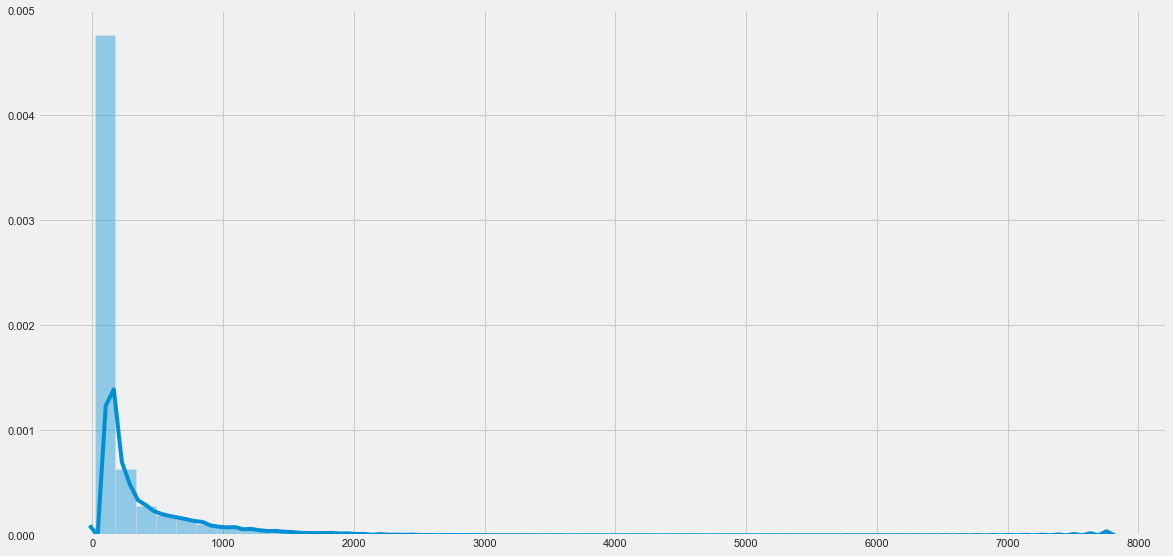

In [68]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

In [69]:
# Combine scripts for the same day.
meeting_script_speaker_df = meeting_script_speaker_df.groupby(['type', 'date', 'title', 'speaker', 'decision', 'rate', 'next_meeting', 'next_decision', 'next_rate'])['text'].apply('[SECTION]'.join).reset_index()
meeting_script_speaker_df['text_sections'] = meeting_script_speaker_df['text'].map(lambda x: x.split("[SECTION]"))
meeting_script_speaker_df['text'] = meeting_script_speaker_df['text'].map(lambda x: x.replace("[SECTION]", ""))
meeting_script_speaker_df['word_count'] = meeting_script_speaker_df['text'].map(get_word_count)
meeting_script_speaker_df


type       date                    title  \
0     meeting_script 1982-10-05  FOMC Meeting Transcript   
1     meeting_script 1982-10-05  FOMC Meeting Transcript   
2     meeting_script 1982-10-05  FOMC Meeting Transcript   
3     meeting_script 1982-10-05  FOMC Meeting Transcript   
4     meeting_script 1982-10-05  FOMC Meeting Transcript   
...              ...        ...                      ...   
6832  meeting_script 2014-12-17  FOMC Meeting Transcript   
6833  meeting_script 2014-12-17  FOMC Meeting Transcript   
6834  meeting_script 2014-12-17  FOMC Meeting Transcript   
6835  meeting_script 2014-12-17  FOMC Meeting Transcript   
6836  meeting_script 2014-12-17  FOMC Meeting Transcript   

                   speaker  decision  rate next_meeting  next_decision  \
0                  CHAIRMA        -1   9.5   1982-11-16             -1   
1         CHAIRMAN VOLCKER        -1   9.5   1982-11-16             -1   
2              MR. AXILROD        -1   9.5   1982-11-16             -1   
3               MR. BALLES        -1   9.5   1982-11-16             -1   
4                MR. BLACK        -1   9.5   1982-11-16             -1   
...                    ...       ...   ...          ...            ...   
6832            MS. GEORGE         0   0.0   2016-01-27              0   
6833              MS. KLEE         0   0.0   2016-01-27              0   
6834             MS. LOGAN         0   0.0   2016-01-27              0   
6835            MS. MESTER         0   0.0   2016-01-27              0   
6836  VICE CHAIRMAN DUDLEY         0   0.0   2016-01-27              0   

      next_rate  \
0          9.00   
1          9.00   
2          9.00   
3          9.00   
4          9.00   
...         ...   
6832       0.25   
6833       0.25   
6834       0.25   
6835       0.25   
6836       0.25   

                                                                                                                                                                                                         text  \
0     VOLCKER.while but it may be that itsurprised me that they werewe don't have thatin our forecast.I thought it had been level for a longgot back to where it was a year ago.Itup that much in a year.V...   
1     Without objection, it is approved. As forthe Mexican swap [drawing], whatever our "druthers," the situation isSo, I don'tthat I don't think they have any money to pay it off.As I understandthink w...   
2     Well, the one that is reserveable certainlywould be in M1.Where the other one would be is a question one wouldhave to consider carefully, I think. It will [allow] at least sixtransfers. Our presen...   
3     Well, coming at this confidence factor from alittle different direction, since as we all know both consumerconfidence and business confidence do play a key part in what reallyI was wondering,happe...   
4     Mr. Chairman, Larry rescued us from the straitsof desperation and said some of the things I had in mind.There aretwo things that might be helpful to remember here. One is that italways looks very,...   
...                                                                                                                                                                                                       ...   
6832  Thank you, Madam Chair. The Tenth District economy has continued toexpand at a relatively steady pace, with the exception of energy and agricultural production.Most of our industry contacts note p...   
6833  4 Thank you. I will be referring to the packet labeled “Material forBriefing on the Summary of Economic Projections.”Exhibit 1 shows the broad trajectories of your forecasts under your individuala...   
6834  Thank you, Madam Chair. I’ll begin again on exhibit 3 with asummary of the recent testing of the term deposit facility and reverse repos, and astaff proposal to continue ON RRP testing in 2015. Th...   
6835  Lorie, I know you revised the memo, and I still don’t fully understandwhy we need

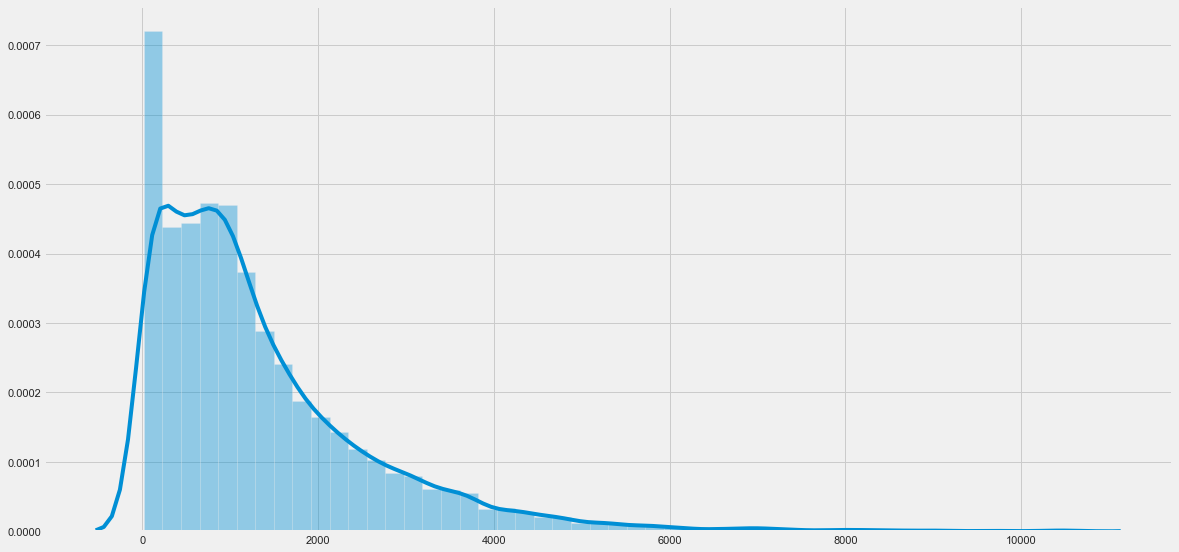

In [70]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [71]:
meeting_script_split_df = get_split_df(meeting_script_speaker_df)
print(meeting_script_split_df.shape)
meeting_script_split_df


(62442, 12)


type       date                    title  \
0      meeting_script 1982-10-05  FOMC Meeting Transcript   
1      meeting_script 1982-10-05  FOMC Meeting Transcript   
2      meeting_script 1982-10-05  FOMC Meeting Transcript   
3      meeting_script 1982-10-05  FOMC Meeting Transcript   
4      meeting_script 1982-10-05  FOMC Meeting Transcript   
...               ...        ...                      ...   
62437  meeting_script 2014-12-17  FOMC Meeting Transcript   
62438  meeting_script 2014-12-17  FOMC Meeting Transcript   
62439  meeting_script 2014-12-17  FOMC Meeting Transcript   
62440  meeting_script 2014-12-17  FOMC Meeting Transcript   
62441  meeting_script 2014-12-17  FOMC Meeting Transcript   

                    speaker  decision  rate next_meeting  next_decision  \
0                   CHAIRMA        -1   9.5   1982-11-16             -1   
1                   CHAIRMA        -1   9.5   1982-11-16             -1   
2                   CHAIRMA        -1   9.5   1982-11-16             -1   
3                   CHAIRMA        -1   9.5   1982-11-16             -1   
4                   CHAIRMA        -1   9.5   1982-11-16             -1   
...                     ...       ...   ...          ...            ...   
62437  VICE CHAIRMAN DUDLEY         0   0.0   2016-01-27              0   
62438  VICE CHAIRMAN DUDLEY         0   0.0   2016-01-27              0   
62439  VICE CHAIRMAN DUDLEY         0   0.0   2016-01-27              0   
62440  VICE CHAIRMAN DUDLEY         0   0.0   2016-01-27              0   
62441  VICE CHAIRMAN DUDLEY         0   0.0   2016-01-27              0   

       next_rate  \
0           9.00   
1           9.00   
2           9.00   
3           9.00   
4           9.00   
...          ...   
62437       0.25   
62438       0.25   
62439       0.25   
62440       0.25   
62441       0.25   

                                                                                                                                                                                                          text  \
0      VOLCKER while but it may be that itsurprised me that they werewe don't have thatin our forecast I thought it had been level for a longgot back to where it was a year ago Itup that much in a year V...   
1      the guy payingthe highest rate And that will tend to force the rates higher Iwould think there would be two tendencies initially To pay a moneybill rate My guess would be that the bill rate fellow...   
2      going on particularly with respect to Argentina andYugoslavia of central banking monetary authority packages The is whether those packages are big enough for the situation inboth cases As I said t...   
3      case of Mexico I don't know if it's goingto come up I hope it doesn't My position is that it should not comeup On the other hand I cannot exclude it given the nature of theproblem VOLCKER Let me s...   
4      is affected by recession high interestBut I think it's patently obvious thatrates and all the rest Mexico was going to borrow all it could borrow and all the banks weregoing to give them and at so...   
...                                                                                                                                                                                                        ...   
62437  as we think we cando so safely Although we refer to a rise in the federal funds rate target as a tightening ofmonetary policy and this harkens back to what Stan was saying there s a problem there ...   
62438  monetary policy to the real economy works through thetransmission channel of financial market conditions So if it s like the taper tantrum episode andif financial conditions were to tighten signif...   
62439  might be quite poorat first In my mind raising short term rates for the first time in more than six years is asubstantial regime shift Finally given all of the uncertainties about how financial co...   
62440  therisks of disruption to global fi

### Filter out by keywords

In [72]:
# Keep sections having keywords and long enough
meeting_script_keyword_df = remove_short_nokeyword(meeting_script_speaker_df)
meeting_script_keyword_df.reset_index(drop=True, inplace=True)
print(meeting_script_keyword_df.shape)
meeting_script_keyword_df


(4698, 12)


type       date                    title  \
0     meeting_script 1982-10-05  FOMC Meeting Transcript   
1     meeting_script 1982-10-05  FOMC Meeting Transcript   
2     meeting_script 1982-10-05  FOMC Meeting Transcript   
3     meeting_script 1982-10-05  FOMC Meeting Transcript   
4     meeting_script 1982-10-05  FOMC Meeting Transcript   
...              ...        ...                      ...   
4693  meeting_script 2014-12-17  FOMC Meeting Transcript   
4694  meeting_script 2014-12-17  FOMC Meeting Transcript   
4695  meeting_script 2014-12-17  FOMC Meeting Transcript   
4696  meeting_script 2014-12-17  FOMC Meeting Transcript   
4697  meeting_script 2014-12-17  FOMC Meeting Transcript   

                   speaker  decision  rate next_meeting  next_decision  \
0                  CHAIRMA        -1   9.5   1982-11-16             -1   
1         CHAIRMAN VOLCKER        -1   9.5   1982-11-16             -1   
2               MR. BOEHNE        -1   9.5   1982-11-16             -1   
3             MR. CORRIGAN        -1   9.5   1982-11-16             -1   
4                 MR. FORD        -1   9.5   1982-11-16             -1   
...                    ...       ...   ...          ...            ...   
4693            MS. GEORGE         0   0.0   2016-01-27              0   
4694              MS. KLEE         0   0.0   2016-01-27              0   
4695             MS. LOGAN         0   0.0   2016-01-27              0   
4696            MS. MESTER         0   0.0   2016-01-27              0   
4697  VICE CHAIRMAN DUDLEY         0   0.0   2016-01-27              0   

      next_rate  \
0          9.00   
1          9.00   
2          9.00   
3          9.00   
4          9.00   
...         ...   
4693       0.25   
4694       0.25   
4695       0.25   
4696       0.25   
4697       0.25   

                                                                                                                                                                                                         text  \
0     VOLCKER.I think there will be a tendency amongsome to pay a money market funds rate plus; the question is whetherthe market gets driven there.I'm just guessing. Among other things,we approved what...   
1     I will mention one other aspect of thisand then I want to go back to somewhat broader subjects.If there isa big drain on money market funds, there probably will be a big drainon bank CDs.Money mar...   
2     Well, I think how one comes out on this dependson whether one wants to take the risks on rules or on the side ofdiscretion.It does seem to me that we have pushed the domesticeconomy and the financ...   
3     Mr. Chairman, I clearly would fall on the sideof the argument that says we don't want an increase in interest rates,even by accident.An increase in interest rates in the currentsetting, even if it...   
4     What you are saying quite plainly, if I hear youcorrectly, is that you think rates are too high now and you don't wanteven a tiny increase from the present rate of 10-1/4 percent on thefed funds r...   
...                                                                                                                                                                                                       ...   
4693  Thank you, Madam Chair. The Tenth District economy has continued toexpand at a relatively steady pace, with the exception of energy and agricultural production.Most of our industry contacts note p...   
4694  4 Thank you. I will be referring to the packet labeled “Material forBriefing on the Summary of Economic Projections.”Exhibit 1 shows the broad trajectories of your forecasts under your individuala...   
4695  Thank you, Madam Chair. I’ll begin again on exhibit 3 with asummary of the recent testing of the term deposit facility and reverse repos, and astaff proposal to continue ON RRP testing in 2015. Th...   
4696  Thank you, Madam Chair. My overall view is that the economy isbuilding momentum i

In [73]:
# Drop text during the process to reduce the output size
meeting_script_speaker_df.drop(columns=['text_sections'], inplace=True)
meeting_script_split_df.drop(columns=['text_sections'], inplace=True)
meeting_script_keyword_df.drop(columns=['text_sections'], inplace=True)

## Speech DataFrame

In [74]:
# Reorganize the dataframe
proc_speech_df = reorganize_df(speech_df, 'speech')

No rate decision found:  1538
Shape of the dataframe:  (1538, 13)


In [75]:
# Check the returned dataframe
# Note that rate and decision are not applicable because speech is not at FOMC meeting
proc_speech_df

type       date  \
0     speech 1996-06-13   
1     speech 1996-06-18   
2     speech 1996-09-08   
3     speech 1996-09-19   
4     speech 1996-10-02   
...      ...        ...   
1533  speech 2021-07-30   
1534  speech 2021-08-03   
1535  speech 2021-08-04   
1536  speech 2021-08-05   
1537  speech 2021-08-17   

                                                                   title  \
0                                    Bank supervision in a world economy   
1                           Developments in electronic money and banking   
2                                Monetary policy objectives and strategy   
3                              Regulation and electronic payment systems   
4                                         Small business is big business   
...                                                                  ...   
1533  Assessing Progress as the Economy Moves from Reopening to Recovery   
1534                                                   Welcoming Remarks   
1535          Outlooks, Outcomes, and Prospects for U.S. Monetary Policy   
1536                            CBDC: A Solution in Search of a Problem?   
1537                                                  Welcoming Remarks    

                             speaker  word_count  decision  rate next_meeting  \
0            Chairman Alan Greenspan        3211      <NA>  None   1996-07-03   
1     Governor Edward W. Kelley, Jr.        2694      <NA>  None   1996-07-03   
2         Governor Laurence H. Meyer        2902      <NA>  None   1996-09-24   
3            Chairman Alan Greenspan        1988      <NA>  None   1996-09-24   
4       Governor Lawrence B. Lindsey        2180      <NA>  None   1996-11-13   
...                              ...         ...       ...   ...          ...   
1533          Governor Lael Brainard        1578      <NA>  None          NaT   
1534     Governor Michelle W. Bowman        1015      <NA>  None          NaT   
1535   Vice Chair Richard H. Clarida        2232      <NA>  None          NaT   
1536  Governor Christopher J. Waller        3114      <NA>  None          NaT   
1537          Chair Jerome H. Powell         815      <NA>  None          NaT   

      next_decision  next_rate  \
0                 0       5.25   
1                 0       5.25   
2                 0       5.25   
3                 0       5.25   
4                 0       5.25   
...             ...        ...   
1533           <NA>        NaN   
1534           <NA>        NaN   
1535           <NA>        NaN   
1536           <NA>        NaN   
1537           <NA>        NaN   

                                                                                                                                                                                                         text  \
0     Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996[SECTION][SECTION]I am honored to present...   
1     Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996[SECTION][SECTION]It is a pleasure to be here th...   
2     Monetary Policy Objectives and Strategy[SECTION]I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment.  But I also want ...   
3     Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996[SE...   
4     Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996[SECTION][SECTION]Small Business Is Big Business[SECTION]It is my pleasure to ...   
...                                                                                                                                   

(1538, 13)


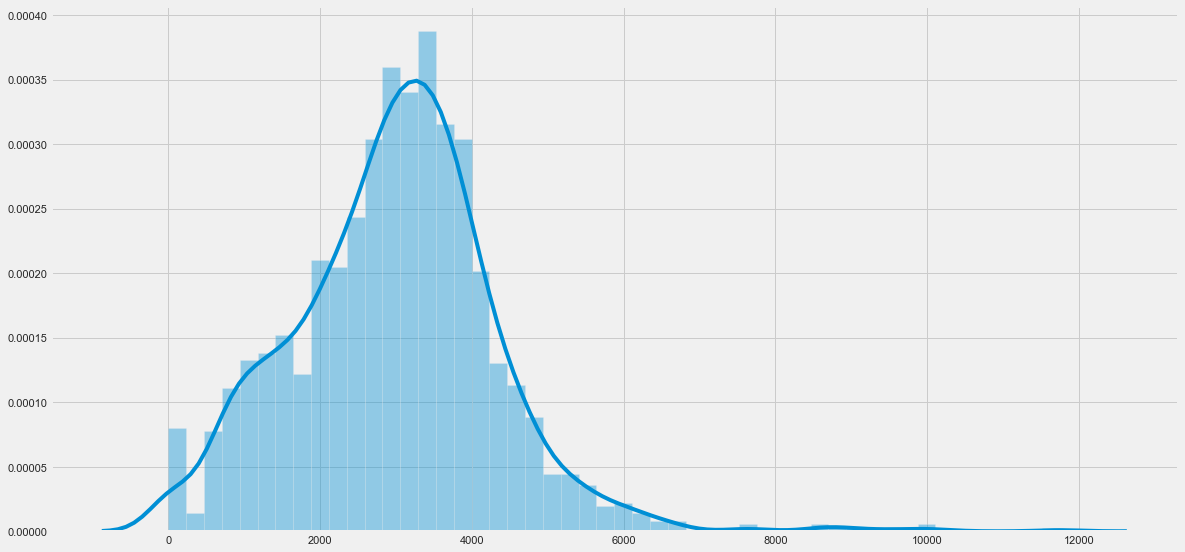

In [76]:
print(proc_speech_df.shape)
sns.distplot(proc_speech_df["word_count"].values, bins=50)

In [77]:
# Check records where speaker is null
proc_speech_df['speaker'].isnull().sum()

0

In [78]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_speech_df = remove_short_section(proc_speech_df, min_words=50)
proc_speech_df


type       date  \
0     speech 1996-06-13   
1     speech 1996-06-18   
2     speech 1996-09-08   
3     speech 1996-09-19   
4     speech 1996-10-02   
...      ...        ...   
1533  speech 2021-07-30   
1534  speech 2021-08-03   
1535  speech 2021-08-04   
1536  speech 2021-08-05   
1537  speech 2021-08-17   

                                                                   title  \
0                                    Bank supervision in a world economy   
1                           Developments in electronic money and banking   
2                                Monetary policy objectives and strategy   
3                              Regulation and electronic payment systems   
4                                         Small business is big business   
...                                                                  ...   
1533  Assessing Progress as the Economy Moves from Reopening to Recovery   
1534                                                   Welcoming Remarks   
1535          Outlooks, Outcomes, and Prospects for U.S. Monetary Policy   
1536                            CBDC: A Solution in Search of a Problem?   
1537                                                  Welcoming Remarks    

                             speaker  word_count  decision  rate next_meeting  \
0            Chairman Alan Greenspan        3095      <NA>  None   1996-07-03   
1     Governor Edward W. Kelley, Jr.        2659      <NA>  None   1996-07-03   
2         Governor Laurence H. Meyer        2729      <NA>  None   1996-09-24   
3            Chairman Alan Greenspan        1586      <NA>  None   1996-09-24   
4       Governor Lawrence B. Lindsey        2002      <NA>  None   1996-11-13   
...                              ...         ...       ...   ...          ...   
1533          Governor Lael Brainard        1385      <NA>  None          NaT   
1534     Governor Michelle W. Bowman         785      <NA>  None          NaT   
1535   Vice Chair Richard H. Clarida        2063      <NA>  None          NaT   
1536  Governor Christopher J. Waller        2920      <NA>  None          NaT   
1537          Chair Jerome H. Powell         546      <NA>  None          NaT   

      next_decision  next_rate  \
0                 0       5.25   
1                 0       5.25   
2                 0       5.25   
3                 0       5.25   
4                 0       5.25   
...             ...        ...   
1533           <NA>        NaN   
1534           <NA>        NaN   
1535           <NA>        NaN   
1536           <NA>        NaN   
1537           <NA>        NaN   

                                                                                                                                                                                                         text  \
0     I am honored to present the William Taylor Memorial     Lecture to such a distinguished group of senior bank supervisors     from around the world.  I am especially delighted to have with us     B...   
1     It is a pleasure to be here this afternoon to provide     the Federal Reserve's perspective on recent developments in the     field of electronic money and banking.  To begin, let me remind     yo...   
2     I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment.  But I also want to emphasize the importance of setting monetary ...   
3     You have heard many points of view today on electronic moneyand banking.  New products are being designed to challenge theuse of currency and checks in millions of routine consumertransactions.  O...   
4     A fair question might be, what is the nation's central bank doing sponsoring aconference on small business?   Well, let me be clear about one thing, neither I nor mycolleagues from the Fed are goi...   
...                                                                                                                                   

In [79]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_speech_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_speech_df.columns
speech_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)

print(speech_chair_df.shape)
speech_chair_df

(434, 13)


type       date  \
0    speech 1996-06-13   
1    speech 1996-09-19   
2    speech 1996-10-05   
3    speech 1996-10-07   
4    speech 1996-10-16   
..      ...        ...   
429  speech 2020-10-06   
430  speech 2021-02-10   
431  speech 2021-03-18   
432  speech 2021-05-03   
433  speech 2021-08-17   

                                                                title  \
0                                 Bank supervision in a world economy   
1                           Regulation and electronic payment systems   
2                              Bank supervision, regulation, and risk   
3    U.S. Treasury securities market: Lessons from Alexander Hamilton   
4                             Technological advances and productivity   
..                                                                ...   
429             Recent Economic Developments and the Challenges Ahead   
430                             Getting Back to a Strong Labor Market   
431                                                   Closing Remarks   
432                                             Community Development   
433                                                Welcoming Remarks    

            speaker  word_count decision  rate next_meeting next_decision  \
0    Alan Greenspan        3095     <NA>  None   1996-07-03             0   
1    Alan Greenspan        1586     <NA>  None   1996-09-24             0   
2    Alan Greenspan        2183     <NA>  None   1996-11-13             0   
3    Alan Greenspan         985     <NA>  None   1996-11-13             0   
4    Alan Greenspan        1615     <NA>  None   1996-11-13             0   
..              ...         ...      ...   ...          ...           ...   
429   Jerome Powell        2000     <NA>  None   2020-11-05             0   
430   Jerome Powell        2264     <NA>  None   2021-03-17             0   
431   Jerome Powell         693     <NA>  None   2021-04-28             0   
432   Jerome Powell         992     <NA>  None   2021-06-16             0   
433   Jerome Powell         546     <NA>  None          NaT          <NA>   

     next_rate  \
0         5.25   
1         5.25   
2         5.25   
3         5.25   
4         5.25   
..         ...   
429       0.00   
430       0.00   
431       0.00   
432       0.00   
433        NaN   

                                                                                                                                                                                                        text  \
0    I am honored to present the William Taylor Memorial     Lecture to such a distinguished group of senior bank supervisors     from around the world.  I am especially delighted to have with us     B...   
1    You have heard many points of view today on electronic moneyand banking.  New products are being designed to challenge theuse of currency and checks in millions of routine consumertransactions.  O...   
2    You may well wonder why a regulator is the first speaker at a conference in which amajor theme is maximizing shareholder value.  I hope that by the end of my remarks thismorning it will be clear t...   
3    I thank the members of the Public Securities Association for bestowing upon me this award for distinguished public service.  I am particularly honored by the company that I keep as a winner of thi...   
4    The Conference Board has been an important institution in my life.  It was where I started as an economist.  It was where I came into contact with a business world I had never known before.  The y...   
..                                                                                                                                                                                                       ...   
429  Good morning. It has been just eight months since the pandemic first gained a foothold on our shores, bringing with it the sharpest downturn on record, as well as the most forceful policy response...   
430  Today 

### Split contents to max 200 words

In [80]:
speech_split_df = get_split_df(speech_chair_df)
speech_split_df.reset_index(drop=True, inplace=True)
print(speech_split_df.shape)
speech_split_df


(7117, 13)


type       date                                title         speaker  \
0     speech 1996-06-13  Bank supervision in a world economy  Alan Greenspan   
1     speech 1996-06-13  Bank supervision in a world economy  Alan Greenspan   
2     speech 1996-06-13  Bank supervision in a world economy  Alan Greenspan   
3     speech 1996-06-13  Bank supervision in a world economy  Alan Greenspan   
4     speech 1996-06-13  Bank supervision in a world economy  Alan Greenspan   
...      ...        ...                                  ...             ...   
7112  speech 2021-05-03                Community Development   Jerome Powell   
7113  speech 2021-08-17                   Welcoming Remarks    Jerome Powell   
7114  speech 2021-08-17                   Welcoming Remarks    Jerome Powell   
7115  speech 2021-08-17                   Welcoming Remarks    Jerome Powell   
7116  speech 2021-08-17                   Welcoming Remarks    Jerome Powell   

      word_count  decision  rate next_meeting  next_decision  next_rate  \
0            200      <NA>  None   1996-07-03              0       5.25   
1            200      <NA>  None   1996-07-03              0       5.25   
2            200      <NA>  None   1996-07-03              0       5.25   
3            200      <NA>  None   1996-07-03              0       5.25   
4            200      <NA>  None   1996-07-03              0       5.25   
...          ...       ...   ...          ...            ...        ...   
7112          92      <NA>  None   2021-06-16              0       0.00   
7113         200      <NA>  None          NaT           <NA>        NaN   
7114         200      <NA>  None          NaT           <NA>        NaN   
7115         200      <NA>  None          NaT           <NA>        NaN   
7116          96      <NA>  None          NaT           <NA>        NaN   

                                                                                                                                                                                                         text  \
0     I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world I am especially delighted to have with us Bill's wife Sha...   
1     best from himself and from those around him He understood that a safe and sound banking system was essential to a healthy market system and he was committed to maintaining such a system His contri...   
2     reflect the increased efficiency of financial markets worldwide which have helped to bring about expanded international trade and economic growth However by strengthening the interdependencies amo...   
3     relationship we may have a better framework for considering how to supervise and regulate our financial institutions A Leveraged Banking System In addressing these issues it is important to rememb...   
4     of intermediation with the founding of the Riksbank more than years ago as a private institution Of course this same leverage and risk taking also greatly increases the possibility of bank failure...   
...                                                                                                                                                                                                       ...   
7112  with invaluable technical assistance to help them weather the downturn and you have helped them get the funds they need to support their businesses NCRC member groups have contributed in so many w...   
7113  Thank you Gigi and Scott and thanks to everyone for your work in bringing us together today particularly the Economic Education Group Congratulations on the launch of Economic Education Month as w...   
7114  reality At the Fed we take the value and responsibility of public service pretty seriously and there really is no greater contribution to the common good than teaching The pandemic has been tough ...   
7115  have been missed and a once in a lifetime crisis h

### Filter out by keyword

In [81]:
# Keep sections having keywords and long enough
speech_keyword_df = remove_short_nokeyword(speech_chair_df)
speech_keyword_df.reset_index(drop=True, inplace=True)
print(speech_keyword_df.shape)
speech_keyword_df


(223, 13)


type       date  \
0    speech 1996-10-05   
1    speech 1996-12-06   
2    speech 1997-01-14   
3    speech 1997-02-21   
4    speech 1997-04-29   
..      ...        ...   
218  speech 2020-04-09   
219  speech 2020-08-27   
220  speech 2020-10-06   
221  speech 2021-02-10   
222  speech 2021-05-03   

                                                            title  \
0                          Bank supervision, regulation, and risk   
1                                                 Social security   
2                              Central banking and global finance   
3                  Government regulation and derivative contracts   
4                                     G-7 economic summit meeting   
..                                                            ...   
218                                      COVID-19 and the Economy   
219  New Economic Challenges and the Fed's Monetary Policy Review   
220         Recent Economic Developments and the Challenges Ahead   
221                         Getting Back to a Strong Labor Market   
222                                         Community Development   

            speaker  word_count decision  rate next_meeting next_decision  \
0    Alan Greenspan         136     <NA>  None   1996-11-13             0   
1    Alan Greenspan         253     <NA>  None   1996-12-17             0   
2    Alan Greenspan         133     <NA>  None   1997-02-05             0   
3    Alan Greenspan         212     <NA>  None   1997-03-25             1   
4    Alan Greenspan         142     <NA>  None   1997-05-20             0   
..              ...         ...      ...   ...          ...           ...   
218   Jerome Powell          53     <NA>  None   2020-04-29             0   
219   Jerome Powell        1172     <NA>  None   2020-09-16             0   
220   Jerome Powell         413     <NA>  None   2020-11-05             0   
221   Jerome Powell         433     <NA>  None   2021-03-17             0   
222   Jerome Powell          83     <NA>  None   2021-06-16             0   

     next_rate  \
0         5.25   
1         5.25   
2         5.25   
3         5.50   
4         5.50   
..         ...   
218       0.00   
219       0.00   
220       0.00   
221       0.00   
222       0.00   

                                                                                                                                                                                                        text  \
0    While awaiting perfection, it is useful to underline that regulators and banks have acommon interest in using the evolving new technologies to meet their own separateobjectives:  maximizing shareh...   
1    While such evaluations are based on an uncertain future, the benefit per current retiree under existing law, adjusted for inflation, can be forecast with some precision over the next thirty years....   
2    In theory, the allocation of responsibility for risk-bearing between the private sectorand the central bank depends upon an evaluation of the private cost of capital.  In order toattract, or at le...   
3    In the case of the institutional off-exchange derivatives markets, it seems abundantly clear that private market regulation is quite effectively and efficiently achieving what have been identified...   
4    In theory, the allocation of responsibility for risk-bearing between the private sector and the central bank depends upon an evaluation of the private cost of capital.  In order to attract, or at ...   
..                                                                                                                                                                                                       ...   
218  To those ends, we have lowered interest rates to near zero in order to bring down borrowing costs. We have also committed to keeping rates at this low level until we are confident that the economy...   
219  Our evolving understanding of four key economic develo

In [82]:
# Drop text_sections
speech_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Testimony DataFrame

In [83]:
# Reorganize the dataframe
# Note that rate and decision are not applicable because testimony is not at FOMC meeting
proc_testimony_df = reorganize_df(testimony_df, 'testimony')

No rate decision found:  449
Shape of the dataframe:  (449, 13)


In [84]:
# Check the returned dataframe
proc_testimony_df

type       date  \
0    testimony 1996-06-26   
1    testimony 1996-07-17   
2    testimony 1996-07-18   
3    testimony 1996-07-24   
4    testimony 1996-07-26   
..         ...        ...   
444  testimony 2021-03-23   
445  testimony 2021-04-15   
446  testimony 2021-05-19   
447  testimony 2021-06-22   
448  testimony 2021-07-14   

                                                                                                                                                          title  \
0                                                                                                                           Supervision of bank sales practices   
1                                                                                                                                          "Prime bank" schemes   
2                                                                                                              The Federal Reserve's semiannual monetary report   
3                                                                                                                                    Trends in consumer lending   
4                                                                                                                  Recent reports on Federal Reserve operations   
..                                                                                                                                                          ...   
444                                                                                                          Coronavirus Aid, Relief, and Economic Security Act   
445  The End of LIBOR: Transitioning to an Alternative Interest Rate Calculation for Mortgages, Student Loans, Business Borrowing, and Other Financial Products   
446                                                                                                                                  Supervision and Regulation   
447                                                                                                  The Federal Reserve's Response to the Coronavirus Pandemic   
448                                                                                                           Semiannual Monetary Policy Report to the Congress   

                                                                                         speaker  \
0                                                                 Governor Edward W. Kelley, Jr.   
1    Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation   
2                                                                        Chairman Alan Greenspan   
3                                                                       Governor Janet L. Yellen   
4                                                                        Chairman Alan Greenspan   
..                                                                                           ...   
444                                                                       Chair Jerome H. Powell   
445                                                          Mark Van Der Weide, General Counsel   
446                                                 Vice Chair for Supervision Randal K. Quarles   
447                                                                       Chair Jerome H. Powell   
448                                                                       Chair Jerome H. Powell   

     word_count  decision  rate next_meeting  next_decision  next_rate  \
0          2298      <NA>  None   1996-07-03              0       5.25   
1          1227      <NA>  None   1996-08-20              0       5.25   
2          3372      <NA>  None   1996-08-20              0       5.25   
3          2878      <NA>  None   1996-08-20              0       5.25   
4          3764      <NA>  None   1996-08-20              0       5.25   
..          ...       ...   ...          ...            ...

(449, 13)


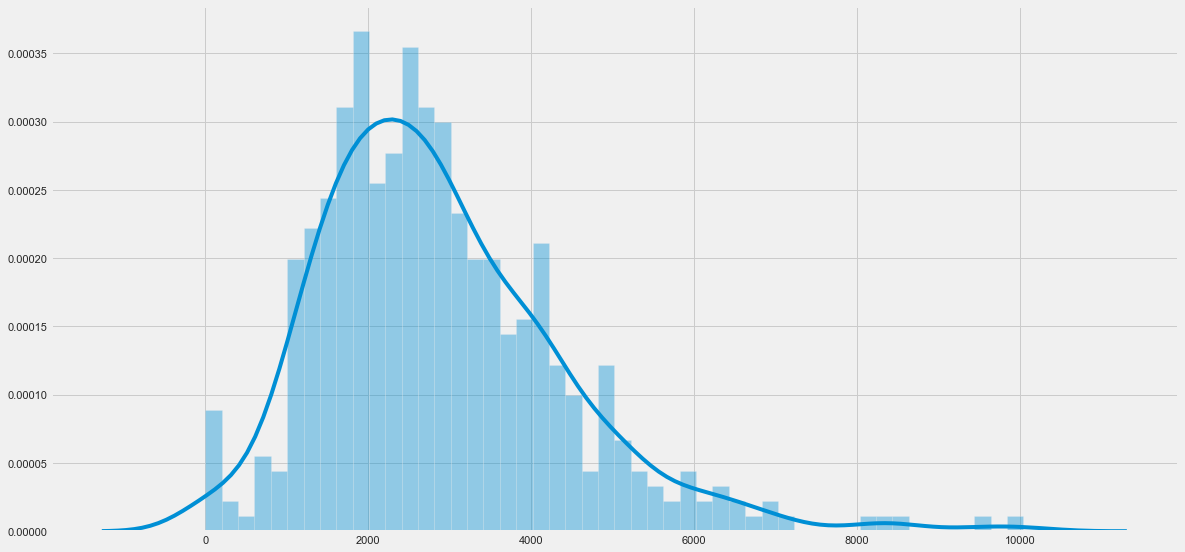

In [85]:
print(proc_testimony_df.shape)
sns.distplot(proc_testimony_df["word_count"].values, bins=50)

In [86]:
# Check records where speaker is null
proc_testimony_df['speaker'].isnull().sum()

0

In [87]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_testimony_df = remove_short_section(proc_testimony_df, min_words=50)
proc_testimony_df

type       date  \
0    testimony 1996-06-26   
1    testimony 1996-07-17   
2    testimony 1996-07-18   
3    testimony 1996-07-24   
4    testimony 1996-07-26   
..         ...        ...   
444  testimony 2021-03-23   
445  testimony 2021-04-15   
446  testimony 2021-05-19   
447  testimony 2021-06-22   
448  testimony 2021-07-14   

                                                                                                                                                          title  \
0                                                                                                                           Supervision of bank sales practices   
1                                                                                                                                          "Prime bank" schemes   
2                                                                                                              The Federal Reserve's semiannual monetary report   
3                                                                                                                                    Trends in consumer lending   
4                                                                                                                  Recent reports on Federal Reserve operations   
..                                                                                                                                                          ...   
444                                                                                                          Coronavirus Aid, Relief, and Economic Security Act   
445  The End of LIBOR: Transitioning to an Alternative Interest Rate Calculation for Mortgages, Student Loans, Business Borrowing, and Other Financial Products   
446                                                                                                                                  Supervision and Regulation   
447                                                                                                  The Federal Reserve's Response to the Coronavirus Pandemic   
448                                                                                                           Semiannual Monetary Policy Report to the Congress   

                                                                                         speaker  \
0                                                                 Governor Edward W. Kelley, Jr.   
1    Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation   
2                                                                        Chairman Alan Greenspan   
3                                                                       Governor Janet L. Yellen   
4                                                                        Chairman Alan Greenspan   
..                                                                                           ...   
444                                                                       Chair Jerome H. Powell   
445                                                          Mark Van Der Weide, General Counsel   
446                                                 Vice Chair for Supervision Randal K. Quarles   
447                                                                       Chair Jerome H. Powell   
448                                                                       Chair Jerome H. Powell   

     word_count  decision  rate next_meeting  next_decision  next_rate  \
0          2071      <NA>  None   1996-07-03              0       5.25   
1           959      <NA>  None   1996-08-20              0       5.25   
2          2966      <NA>  None   1996-08-20              0       5.25   
3          2601      <NA>  None   1996-08-20              0       5.25   
4          3308      <NA>  None   1996-08-20              0       5.25   
..          ...       ...   ...          ...            ...

In [88]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_testimony_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_testimony_df.columns
testimony_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
testimony_chair_df

type       date  \
0    testimony 1996-07-18   
1    testimony 1996-07-26   
2    testimony 1997-01-21   
3    testimony 1997-01-30   
4    testimony 1997-02-13   
..         ...        ...   
177  testimony 2020-12-01   
178  testimony 2021-02-23   
179  testimony 2021-03-23   
180  testimony 2021-06-22   
181  testimony 2021-07-14   

                                                          title  \
0              The Federal Reserve's semiannual monetary report   
1                  Recent reports on Federal Reserve operations   
2                                              January 21, 1997   
3                                      The comsumer price index   
4                         Modernization of the financial system   
..                                                          ...   
177          Coronavirus Aid, Relief, and Economic Security Act   
178           Semiannual Monetary Policy Report to the Congress   
179          Coronavirus Aid, Relief, and Economic Security Act   
180  The Federal Reserve's Response to the Coronavirus Pandemic   
181           Semiannual Monetary Policy Report to the Congress   

            speaker  word_count decision  rate next_meeting  next_decision  \
0    Alan Greenspan        2966     <NA>  None   1996-08-20              0   
1    Alan Greenspan        3308     <NA>  None   1996-08-20              0   
2    Alan Greenspan        2854     <NA>  None   1997-02-05              0   
3    Alan Greenspan        2692     <NA>  None   1997-02-05              0   
4    Alan Greenspan        4100     <NA>  None   1997-03-25              1   
..              ...         ...      ...   ...          ...            ...   
177   Jerome Powell        2379     <NA>  None   2020-12-16              0   
178   Jerome Powell        1218     <NA>  None   2021-03-17              0   
179   Jerome Powell         593     <NA>  None   2021-04-28              0   
180   Jerome Powell        1353     <NA>  None   2021-07-28              0   
181   Jerome Powell         991     <NA>  None   2021-07-28              0   

     next_rate  \
0         5.25   
1         5.25   
2         5.25   
3         5.25   
4         5.50   
..         ...   
177       0.00   
178       0.00   
179       0.00   
180       0.00   
181       0.00   

                                                                                                                                                                                                        text  \
0    Before I take this opportunity to discuss the performance of the U.S.economy and the conduct of monetary policy, I would first like to thank theChairman and the other members of this Committee for...   
1    We are strongly committed to ensuring that the Federal Reserve Systemis managed efficiently and effectively.  It is most important to us at the FederalReserve Board and the Reserve Banks, not only...   
2    Mr. Chairman and members of the Committee, I am pleased to appear here today.  In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress.  ...   
3    Mr. Chairman and members of the Committee, I appreciate the opportunity to appear before you today.  The Committee is faced with a number of complex policy issues that will have an important beari...   
4    Madam Chairwoman, members of the Subcommittee on Financial Institutions and Consumer Credit, it is a pleasure to appear here today to present the views of the Federal Reserve Board on some broad i...   
..                                                                                                                                                                                                       ...   
177  The Federal Reserve, along with others across government, is using its policies to help alleviate the economic burden. Since the pandemic's onset, we have taken forceful actions to provide relief ...   
178  At the Federal Reserve, we are st

### Split contents to max 200 words

In [89]:
testimony_split_df = get_split_df(testimony_chair_df)
testimony_split_df.reset_index(drop=True, inplace=True)
print(testimony_split_df.shape)
testimony_split_df


(2878, 13)


type       date                                              title  \
0     testimony 1996-07-18   The Federal Reserve's semiannual monetary report   
1     testimony 1996-07-18   The Federal Reserve's semiannual monetary report   
2     testimony 1996-07-18   The Federal Reserve's semiannual monetary report   
3     testimony 1996-07-18   The Federal Reserve's semiannual monetary report   
4     testimony 1996-07-18   The Federal Reserve's semiannual monetary report   
...         ...        ...                                                ...   
2873  testimony 2021-07-14  Semiannual Monetary Policy Report to the Congress   
2874  testimony 2021-07-14  Semiannual Monetary Policy Report to the Congress   
2875  testimony 2021-07-14  Semiannual Monetary Policy Report to the Congress   
2876  testimony 2021-07-14  Semiannual Monetary Policy Report to the Congress   
2877  testimony 2021-07-14  Semiannual Monetary Policy Report to the Congress   

             speaker  word_count  decision  rate next_meeting  next_decision  \
0     Alan Greenspan         200      <NA>  None   1996-08-20              0   
1     Alan Greenspan         200      <NA>  None   1996-08-20              0   
2     Alan Greenspan         200      <NA>  None   1996-08-20              0   
3     Alan Greenspan         200      <NA>  None   1996-08-20              0   
4     Alan Greenspan         200      <NA>  None   1996-08-20              0   
...              ...         ...       ...   ...          ...            ...   
2873   Jerome Powell         200      <NA>  None   2021-07-28              0   
2874   Jerome Powell         200      <NA>  None   2021-07-28              0   
2875   Jerome Powell         200      <NA>  None   2021-07-28              0   
2876   Jerome Powell         200      <NA>  None   2021-07-28              0   
2877   Jerome Powell          91      <NA>  None   2021-07-28              0   

      next_rate  \
0          5.25   
1          5.25   
2          5.25   
3          5.25   
4          5.25   
...         ...   
2873       0.00   
2874       0.00   
2875       0.00   
2876       0.00   
2877       0.00   

                                                                                                                                                                                                         text  \
0     Before I take this opportunity to discuss the performance of the U S economy and the conduct of monetary policy I would first like to thank theChairman and the other members of this Committee for ...   
1     above their postwar averages About million workers have beenadded to nonfarm payrolls in the first six months of the year and theunemployment rate fell to percent in June Even though the U S econo...   
2     be better than manyanalysts expected An important supporting factor as I pointed out in February wasfavorable conditions in financial markets in the latter part of and early Intermediate and longe...   
3     better than those of many ofour major trading partners The rise in the dollar helps to keep down pricepressures but it also tends to divert domestic demand toward imported goods anddamp exports so...   
4     less rapidly asfinal demand slows some While these are all good reasons to anticipate that economic growth willmoderate some the timing and extent of that downshift are uncertain We havenot as yet...   
...                                                                                                                                                                                                       ...   
2873  and as some of the other pandemic related factors currently weighing them down diminish Inflation has increased notably and will likely remain elevated in coming months before moderating Inflation...   
2874  the Committee's longer run inflation objective Measures of longer term inflation expectations have moved up from their pandemic lows and are in a range that is broadly co

### Filter out by keyword

In [90]:
# Keep sections having keywords and long enough
testimony_keyword_df = remove_short_nokeyword(testimony_chair_df)
testimony_keyword_df.reset_index(drop=True, inplace=True)
print(testimony_keyword_df.shape)
testimony_keyword_df


(128, 13)


type       date  \
0    testimony 1996-07-18   
1    testimony 1997-01-21   
2    testimony 1997-02-26   
3    testimony 1997-03-20   
4    testimony 1997-07-22   
..         ...        ...   
123  testimony 2020-06-30   
124  testimony 2020-12-01   
125  testimony 2021-02-23   
126  testimony 2021-06-22   
127  testimony 2021-07-14   

                                                          title  \
0              The Federal Reserve's semiannual monetary report   
1                                              January 21, 1997   
2       The Federal Reserve's semiannual monetary policy report   
3                               Performance of the U.S. economy   
4       The Federal Reserve's semiannual monetary policy report   
..                                                          ...   
123                                   Coronavirus and CARES Act   
124          Coronavirus Aid, Relief, and Economic Security Act   
125           Semiannual Monetary Policy Report to the Congress   
126  The Federal Reserve's Response to the Coronavirus Pandemic   
127           Semiannual Monetary Policy Report to the Congress   

            speaker  word_count decision  rate next_meeting  next_decision  \
0    Alan Greenspan         628     <NA>  None   1996-08-20              0   
1    Alan Greenspan         549     <NA>  None   1997-02-05              0   
2    Alan Greenspan         286     <NA>  None   1997-03-25              1   
3    Alan Greenspan         160     <NA>  None   1997-03-25              1   
4    Alan Greenspan        1068     <NA>  None   1997-08-19              0   
..              ...         ...      ...   ...          ...            ...   
123   Jerome Powell         197     <NA>  None   2020-07-29              0   
124   Jerome Powell          52     <NA>  None   2020-12-16              0   
125   Jerome Powell         179     <NA>  None   2021-03-17              0   
126   Jerome Powell         214     <NA>  None   2021-07-28              0   
127   Jerome Powell         474     <NA>  None   2021-07-28              0   

     next_rate  \
0         5.25   
1         5.25   
2         5.50   
3         5.50   
4         5.50   
..         ...   
123       0.00   
124       0.00   
125       0.00   
126       0.00   
127       0.00   

                                                                                                                                                                                                        text  \
0    Even though the U.S. economy is using its productive resources intensively,inflation has remained quiescent.  The core inflation rate, measured by the consumerprice index less food and energy pric...   
1    Mr. Chairman and members of the Committee, I am pleased to appear here today.  In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress.  ...   
2    The performance of the U.S. economy over the past    year has been quite favorable.  Real GDP growth picked    up to more than three percent over the four quarters of    1996, as the economy progr...   
3    Indeed, the labor markets bear especially careful watching for signs that such a process is under way.  So far this year, the demand for labor has stayed strong.  Payroll employment grew briskly i...   
4    This strong expansion has produced a          remarkable increase in work opportunities for          Americans.  A net of more than thirteen          million jobs has been created since the       ...   
..                                                                                                                                                                                                       ...   
123  In discussing the actions we have taken, I will begin with monetary policy. In March, we lowered our policy interest rate to near zero, and we expect to maintain interest rates at this level until...   
124  Economic activity has continued t

In [91]:
# Drop text sections
testimony_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Save the train data

In [92]:
# Combine dataframes
text_no_split = pd.concat([proc_statement_df, 
                           proc_minutes_df, 
                           presconf_script_chair_day_df, 
                           meeting_script_speaker_df, 
                           speech_chair_df,
                           testimony_chair_df], sort=False)
text_no_split.reset_index(drop=True, inplace=True)

text_split_200 = pd.concat([split_statement_df, 
                            split_minutes_df, 
                            presconf_script_split_df, 
                            meeting_script_split_df, 
                            speech_split_df, 
                            testimony_split_df], sort=False)
text_split_200.reset_index(drop=True, inplace=True)

text_keyword = pd.concat([keyword_statement_df,
                          keyword_minutes_df,
                          presconf_script_keyword_df,
                          meeting_script_keyword_df, 
                          speech_keyword_df, 
                          testimony_keyword_df], sort=False)
text_keyword.reset_index(drop=True, inplace=True)

In [93]:
def save_data(df, file_name, dir_name='../data/preprocessed/'):
    '''
    Save the given df to pickle file and csv file in the given directory.
    '''
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print("Data Saved to a pickle file in {} !".format(dir_name))

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)
    print("Data Saved to a csv file in {} !".format(dir_name))
    

In [94]:
save_data(text_no_split, 'text_no_split')
save_data(text_split_200, 'text_split_200')
save_data(text_keyword, 'text_keyword')

Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
